### Import all the necessary libs

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from gym_multigrid.envs import MARL_env 

from matplotlib.colors import ListedColormap
from collections import deque
import random
import copy
from collections import OrderedDict
import pandas as pd
import time

seed = 0
np.random.seed(seed)
random.seed(seed)

### Creation of the Marl env functions

In [2]:
class MultiAgentEnvWrapper:
    """
    Wrapper class for CustomMultiAgentEnv that distinguishes between training and testing phases
    """
    
    def __init__(self, is_testing=False, width=10, height=10, max_steps=100, seed=None,
                 agent_positions=None, goal_positions=None, walls=None):
        self.is_testing = is_testing
        self.width = width
        self.height = height
        self.max_steps = max_steps
        self.seed = seed
        self.envs = []  # stores all environments created
        self.initial_states = []
        
        if agent_positions is None or goal_positions is None:
            raise ValueError("agent_positions and goal_positions must be provided")
        
        # Training mode: one env per agent/goal pair
        if not is_testing:
            for agent_pos, goal_pos in zip(agent_positions, goal_positions):
                agents = [{"start": agent_pos, "goal": goal_pos}]
                env = MARL_env.CustomMultiAgentEnv(
                    width=width,
                    height=height,
                    max_steps=max_steps,
                    seed=seed,
                    agents=agents
                )
                
                # Add walls if specified
                if walls:
                    for wall_x, wall_y in walls:
                        env.add_wall(wall_x, wall_y)
                
                self.envs.append(env)
                self.initial_states.append(env.reset()[0])  # Get first agent's observation
        
        # Test mode: one env with all agents and goals
        else:
            agents = [{"start": start, "goal": goal} for start, goal in zip(agent_positions, goal_positions)]
            env = MARL_env.CustomMultiAgentEnv(
                width=width,
                height=height,
                max_steps=max_steps,
                seed=seed,
                agents=agents
            )
            
            # Add walls if specified
            if walls:
                for wall_x, wall_y in walls:
                    env.add_wall(wall_x, wall_y)
            
            self.envs.append(env)
            self.initial_states.append(env.reset())
    
    def reset(self, idx=0):
        return self.envs[idx].reset(), self.get_agent_position(idx=idx)
    def step(self, actions, idx=0):
        """
        Execute a step in the environment with the given actions for each agent.
        
        Args:
            actions: List of actions, one per agent or single action
            idx: Index of the environment to use
            
        Returns:
            observations: List of observations for each agent
            rewards: List of rewards for each agent
            terminated: If the episode is terminated by reaching goals
            truncated: If the episode is truncated by exceeding max steps
            info: Additional information
        """
        # Make sure we're using the right environment
        env = self.envs[idx]
        
        # Different handling for training vs testing
        if not self.is_testing:
            # Training mode - one action for one agent
            if not isinstance(actions, list):
                obs, rewards, terminated, truncated, info = env.step([actions])
                return obs[0], rewards[0], terminated, truncated, info  # Return just the first agent's results
            else:
                obs, rewards, terminated, truncated, info = env.step(actions)
                return obs[0], rewards[0], terminated, truncated, info  # Return just the first agent's results
        else:
            # Testing mode - list of actions for multiple agents
            if not isinstance(actions, list):
                # Convert single action to list if needed
                actions = [actions]
            
            # Make sure we have enough actions for all agents
            if len(actions) < len(env.agents):
                actions = actions + [0] * (len(env.agents) - len(actions))
            obs, rewards, terminated, truncated, info = env.step(actions)
            # Call the environment's step method
            return obs, rewards, terminated, truncated, info

    def visualize(self, idx=0, highlight_masks=None, show=True):
        """
        Visualize the environment at the specified index
        
        Args:
            idx: Index of the environment to visualize
            highlight_masks: Optional mask to highlight specific cells
            show: Whether to display the image (True) or just return it (False)
        
        Returns:
            numpy.ndarray: The rendered grid image
        """
        grid_image = self.envs[idx].visualize(highlight_masks=highlight_masks, show=show)
        return grid_image
    
    def get_action_space(self):
        # 1: left, 2: right, 3: up, 4: down, 0: stay
        return list(range(5))
    
    def all_agents_at_goals(self, idx=0):
        return self.envs[idx].all_agents_at_goals()
    
    def run_random_agents(self, max_steps=100, idx=0):
        self.envs[idx].run_random_agents(max_steps)
    
    def get_agent_position(self, idx=0):
        """Get the current position of the agent."""
        if self.is_testing:
            return tuple(self.envs[0].agents[idx].pos)
        else:
            return tuple(self.envs[idx].agents[0].pos)
    def collision():
        return MARL_env.CustomMultiAgentEnv.are_agents_colliding()
    def get_agent_goal(self, idx=0):
        """
        Get the goal position of the agent.
        
        Args:
            idx: Index of the agent whose goal position to retrieve
            
        Returns:
            tuple: (x, y) coordinates of the agent's goal position
        """
        if self.is_testing:
            # In testing mode, get the goal for the specified agent
            env = self.envs[0]
            return tuple(env.agent_goals[idx])
        else:
            # In training mode, get the goal for the single agent in the environment
            env = self.envs[idx]
            return tuple(env.agent_goals[0])
    def get_lava_pos(self):
        """
        Get the positions of lava cells in the environment.
        
        Returns:
            list: List of (x, y) coordinates of lava positions
        """
        return self.envs[0].lava_positions

### Pretraining pipeline DynaQ

In [3]:
class DynaQLearningAgent:

    def __init__(self, 
                 state_dim, 
                 action_dim, 
                 lr=0.1, 
                 gamma=0.99, 
                 epsilon=0.4,
                 n_planning=10):
        
        # environment
        self.state_dim = state_dim
        self.action_dim = action_dim

        # hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning

        # model
        self.q_table = dict()
        self.model = dict()

    def action_space(self):
        return [0, 1, 2, 3, 4]  # UP, DOWN, LEFT, RIGHT, STOP

    def best_action(self, array):

        max_value = np.max(array)
        max_indices = np.where(array == max_value)[0]
        action = np.random.choice(max_indices)

        return action
    
    def select_action(self, state, eval=False):
        
        state_index = self.state_to_position(state)

        if state_index not in self.q_table:
            self.q_table[state_index] = np.zeros(self.action_dim)
        
        if not eval and np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)

        action = np.argmax(self.q_table[state_index])
        # action = self.best_action(self.q_table[state_index])
        # if eval:
        #     return np.argmax(self.q_table[state_index])
        
        return action
    
    def q_learning(self, state, action, reward, next_state, done): 

        td_target = reward + self.gamma * (np.max(self.q_table[next_state])) * (1 - done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_error

    def q_planning(self):
        for _ in range(self.n_planning):
            (state, action), (reward, state_next, done) = random.choice(list(self.model.items()))
            self.q_learning(state, action, reward, state_next, done)

    
    def update(self, state, action, reward, next_state, done):

        state_index = (self.state_to_position(state))
        next_state_index = (self.state_to_position(next_state))
        
        if state_index not in self.q_table:
            self.q_table[state_index] = np.zeros(self.action_dim)

        if next_state_index not in self.q_table:
            self.q_table[next_state_index] = np.zeros(self.action_dim)

        self.q_learning(state_index, action, reward, next_state_index, done)
        self.model[(state_index, action)] = reward, next_state_index, done 
        self.q_planning()
        
    def state_to_position(self, state):
        """
        Convert state to a hashable position representation.
        
        Args:
            state: Can be:
                - A tuple (x, y)
                - A tuple containing (observation, position)
                - A list [x, y]
                - A numpy array observation
            
        Returns:
            A hashable tuple representing the agent's position
        """
        if isinstance(state, tuple):
            # Check if this is a tuple of (observation, position)
            if len(state) == 2 and isinstance(state[1], tuple):
                return state[1]  # Return the position part
            return state  # It's already a position tuple
        elif isinstance(state, list):
            return tuple(state)  # Convert list to tuple
        elif isinstance(state, np.ndarray):
            # If state is a full observation array and we have env reference
            if hasattr(self, 'env_wrapper') and hasattr(self, 'agent_idx'):
                return self.env_wrapper.get_agent_position(self.agent_idx)
            else:
                print("Cannot extract position from numpy array without env_wrapper reference")
                return (0, 0)  # Default fallback
        else:
            print(f"Error: Unexpected state type: {type(state)}")
            return (0, 0)  # Default fallback

    def print_tables(self, name):
        if name == 'qtable':
            table = self.q_table
            print(f"{len(table)} out of {(SHAPE[0])*(SHAPE[1])} grids have been reached.")
            col_names=['UP', 'DOWN', 'LEFT', 'RIGHT', 'STOP']
            # col_names=['UP', 'DOWN', 'LEFT', 'RIGHT']
        elif name == 'model':
            table = self.model
            print(f"{len(self.model)} out of {(SHAPE[0])*(SHAPE[1])*self.action_dim} possibilities have been memorized.")
            col_names=['Reward', 'NextState', 'Done']
        else:
            print("Invalid table name.")
            return

        ordered_coords_dict =  OrderedDict(sorted(table.items())).copy()
        df = pd.DataFrame.from_dict(ordered_coords_dict, orient='index', columns=col_names)
        df = df.round(2)
        print(df)

        return [len(table), (SHAPE[0]-2)*(SHAPE[1]-2), len(self.model), (SHAPE[0]-2)*(SHAPE[1]-2)*self.action_dim]
    
    def tables_2(self):
        return [len(self.q_table), len(self.model)]

### Functions for Pretraining all the agents

In [4]:
def train_agent(env_wrapper, agent: DynaQLearningAgent, num_episodes=1000, max_steps=1000, print_process=True, agent_idx=0):
    """
    Entraîne un agent dans un environnement donné (env_wrapper) sur plusieurs épisodes.
    """
    all_rewards = []

    for episode in range(num_episodes):
        # Reset environment and get initial state (which now includes position)
        state = env_wrapper.reset(agent_idx)  # This now returns (observation, position)
        total_reward = 0
        
        if print_process and episode % 10 == 0:
            print(f"Episode {episode}, Agent {agent_idx+1}")
        
        for i in range(max_steps):
            action = agent.select_action(state, eval=False)
            next_state, reward, terminated, truncated, info = env_wrapper.step(action, agent_idx)
            done = terminated or truncated
            
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break

        all_rewards.append(total_reward)

        if print_process and episode % 10 == 0:
            print(f"Episode {episode}, Total Reward for Agent {agent_idx+1}: {total_reward}")
    
    return all_rewards
def smooth(data, weight=0.9):  
    """
    Lisse les données en utilisant un facteur de pondération (smooth).
    :param data: La liste des données à lisser.
    :param weight: Le facteur de pondération utilisé pour le lissage.
    :return: La liste des données lissées.
    """
    last = data[0]
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards_for_all_agents(all_rewards, filename='rewards.png'):
    """
    Trace les récompenses pour tous les agents après l'entraînement.
    
    :param all_rewards: Une liste des récompenses pour chaque agent.
    :param filename: Le nom du fichier pour enregistrer le graphique.
    """
    plt.figure(figsize=(10, 6))

    for idx, rewards in enumerate(all_rewards):
        smoothed_rewards = smooth(rewards)  # Lissage des récompenses
        plt.plot(smoothed_rewards, label=f"Agent {idx+1}")  # Tracer les récompenses lissées
    
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Q-learning for Multiple Agents')
    plt.legend()
    plt.show()

    print(f"Plot saved as {filename}")

def train_all_agents(env_wrapper, agents, num_episodes=1000, max_steps=1000):
    """
    Entraîne plusieurs agents indépendamment dans un environnement multi-agent.
    
    :param env_wrapper: Le wrapper de l'environnement avec plusieurs agents.
    :param agents: Une liste d'agents à entraîner.
    :param num_episodes: Nombre d'épisodes pour l'entraînement de chaque agent.
    :param max_steps: Nombre maximal d'étapes par épisode.
    :return: Une liste des récompenses pour chaque agent.
    """
    all_agents_rewards = []
    
    for idx, agent in enumerate(agents):
        print(f"\nTraining Agent {idx+1}...")
        agent_rewards = train_agent(env_wrapper, agent, num_episodes, max_steps, agent_idx=idx)
        all_agents_rewards.append(agent_rewards)
    
    return all_agents_rewards
# Après l'entraînement de tous les agents, vous pouvez afficher leur Q-table comme suit :

def print_qtables(agents):
    for idx, agent in enumerate(agents):
        print(f"\nQ-table for Agent {idx+1}:")
        agent.print_tables('qtable')  # Utilise la fonction print_tables pour afficher la Q-table





### Movement Model

In [5]:
def model_state(state,action):

    pos= state
    next_pos_array = np.array(pos)
    
    # Traitement explicite pour l'action "stay"
    if action == 0:
        next_pos = pos  # Rester sur place
    elif action == 1:  # west/left
        next_pos_array[0] -= 1
        next_pos = tuple(next_pos_array)
    elif action == 2:  # east/right
        next_pos_array[0] += 1
        next_pos = tuple(next_pos_array)
    elif action == 3:  # north/up
        next_pos_array[1] -= 1
        next_pos = tuple(next_pos_array)
    elif action == 4:  # south/down
        next_pos_array[1] += 1
        next_pos = tuple(next_pos_array)
    return next_pos

### SETS

* Computing the reachable set in `n_steps`
* Computing the `n_steps` unsafe set between two agents as the intersection of their reachable sets in `n_steps`
* Computing the `n_steps` unsafe set of agent $i$ by taking the union over all pairwise unsafe sets


In [6]:
def compute_reachable_states(env, agent_idx=0, start_pos=None, n_steps=5):
    """
    Computes all states reachable for an agent in n_steps.
    
    Args:
        env: The MultiAgentEnvWrapper environment
        agent_idx: Index of the agent to compute reachable states for
        start_pos: Optional starting position, defaults to agent's current position
        n_steps: Number of steps to look ahead
        
    Returns:
        tuple: (reachable_by_step, all_reachable)
            - reachable_by_step: Dict mapping step number to set of positions {step: {positions}}
            - all_reachable: Set of all reachable positions
    """
    start_pos = start_pos or env.get_agent_position(agent_idx)
    queue = deque([(start_pos, 0)])  
    visited = {start_pos} 
    reachable = {0: {start_pos}}  

    actions = [0, 1, 2, 3, 4]  

    while queue:
        pos, steps = queue.popleft()
        
        if steps >= n_steps:
            continue
            
        for action in actions:
            next_pos= model_state(pos, action)

            if action == 0:
                if next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, steps + 1))
                    if steps + 1 not in reachable:
                        reachable[steps + 1] = set()
                    reachable[steps + 1].add(next_pos)
                continue
            
            # Check boundaries
            if (0 <= next_pos[0] < env.width and 
                0 <= next_pos[1] < env.height):
                if env.is_testing:
                    grid = env.envs[0].grid
                else:
                    if agent_idx < len(env.envs):
                        grid = env.envs[agent_idx].grid
                    else:
                        continue

                if next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, steps + 1))

                    if steps + 1 not in reachable:
                        reachable[steps + 1] = set()
                    reachable[steps + 1].add(next_pos)
    all_reachable = set()
    for step in reachable:
        all_reachable.update(reachable[step])
    
    return reachable, all_reachable

def n_unsafe_set(env, agent_idx1=0, agent_idx2=1, n=5):
    """
    Computes the unsafe set for two agents in n steps.
    
    Args:
        env: The environment wrapper
        agent_idx1: Index of the first agent
        agent_idx2: Index of the second agent
        n: Number of steps to look ahead
        
    Returns:
        dict: Unsafe states where both agents could potentially collide, by step
    """
    if env.is_testing:
        num_agents = len(env.envs[0].agents) if env.envs else 0
    else:
        num_agents = len(env.envs)
        
    if agent_idx1 >= num_agents or agent_idx2 >= num_agents:
        
        return {}  
    
    _, all_reachable_agent_1 = compute_reachable_states(env, agent_idx=agent_idx1, n_steps=n)
    _, all_reachable_agent_2 = compute_reachable_states(env, agent_idx=agent_idx2, n_steps=n)
    
    intersections = all_reachable_agent_1.intersection(all_reachable_agent_2)
    
    unsafe_set = {0: intersections} if intersections else {}
    
    return unsafe_set




def K_agents_n_unsafe_set(env, agent_idx=0, n_steps=4, exclude_indices=None):
    """
    Computes the unsafe set for a specific agent by considering its interaction
    with all other agents in the environment. Also counts how many times each position
    is shared among different agents.
    
    Args:1safety_aware_pipeline_with_deadlock
        env: The MultiAgentEnvWrapper environment
        agent_idx: Index of the agent for which to compute the unsafe set
        n_steps: Number of steps to look ahead
        exclude_indices: Optional list of agent indices to exclude from the computation
        
    Returns:
        dict: Unsafe set for the specified agent with counts of how many agents share each position
    """
    lava_positions = env.get_lava_pos()
    if env.is_testing:
        num_agents = len(env.envs[0].agents) if env.envs else 0
    else:
        num_agents = len(env.envs)
    
    combined_unsafe_set = {}
    position_counts = {}  

    if exclude_indices is None:
        exclude_indices = []

    if agent_idx not in exclude_indices:
        exclude_indices.append(agent_idx)

    for other_idx in range(num_agents):
        if other_idx in exclude_indices:
            continue

        pairwise_unsafe = n_unsafe_set(env, agent_idx1=agent_idx, agent_idx2=other_idx, n=n_steps)

        for step, positions in pairwise_unsafe.items():
            if step not in combined_unsafe_set:
                combined_unsafe_set[step] = set()
                position_counts[step] = {}

            combined_unsafe_set[step].update(positions)

            for pos in positions:
                if pos not in position_counts[step]:
                    position_counts[step][pos] = 1
                else:
                    position_counts[step][pos] += 1
    
    # Add lava positions to the unsafe set with a high count
    for step in range(n_steps + 1):
        if step not in combined_unsafe_set:
            combined_unsafe_set[step] = set()
            position_counts[step] = {}
        
        for lava_pos in lava_positions:
            combined_unsafe_set[step].add(lava_pos)
            position_counts[step][lava_pos] = 1
    
    unsafe_with_counts = {}
    for step, positions in combined_unsafe_set.items():
        unsafe_with_counts[step] = {pos: position_counts[step][pos] for pos in positions}
    
    return unsafe_with_counts

        

### Visualisation

* Functions that allow visualising the reachable sets of an agent
* Functions that allow visualising the unsafe set of all agents




In [7]:
def from_reachable_to_mask(reachable_by_step, env_width, env_height, env, fixed_color=None):
    """
    Convert reachable states to a mask for visualization with better color control.

    Args:
        reachable_by_step: Dict mapping step number to set of positions {step: {positions}}
        env_width: Width of the environment
        env_height: Height of the environment
        env: Reference to environment wrapper
        fixed_color: If provided, use this color index for all positions
        
    Returns:
        np.ndarray: Mask with reachable states
    """
    mask = np.empty((env_width, env_height), dtype=object)
    for i in range(env_width):
        for j in range(env_height):
            mask[i, j] = []

    env_world = env.envs[0].world
    color_count = len(env_world.IDX_TO_COLOR)

    for step, positions in reachable_by_step.items():
     
        for pos in positions:
            x, y = pos
            if 0 <= x < env_width and 0 <= y < env_height:
                color = fixed_color if fixed_color is not None else (step % color_count)
                mask[x, y].append(color)
    
    return mask


def visualize_all_agents_unsafe_sets(env_wrapper, n_steps=4):
    """
    Visualizes the unsafe sets for all agents in the environment.
    
    Args:
        env_wrapper: The MultiAgentEnvWrapper environment
        n_steps: Number of steps to look ahead for computing unsafe sets
    """
    # Determine the number of agents
    if env_wrapper.is_testing:
        num_agents = len(env_wrapper.envs[0].agents) if env_wrapper.envs else 0
    else:
        num_agents = len(env_wrapper.envs)
    
    env_width = env_wrapper.width
    env_height = env_wrapper.height

    for agent_idx in range(num_agents):

        unsafe_set = K_agents_n_unsafe_set(
            env_wrapper, 
            agent_idx=agent_idx, 
            n_steps=n_steps
        )

        unsafe_mask = from_reachable_to_mask(
            unsafe_set, 
            env_width, 
            env_height, 
            env_wrapper,
            fixed_color=0  
        )
        
        env_wrapper.visualize(highlight_masks=unsafe_mask)

### Safety Functions

* `'safety status'`: function that determines whether an action is unsafe with respect to a given unsafe set
* `'select safe action'`: shield mechanism (stay if the action leads to a state in the unsafe set; otherwise, perform the action)
* `'n_steps safety judger'`: checks whether agents' policies lead them into the unsafe set within `n_steps`


In [8]:
def safety_status(state,action,unsafe_set_dict):
    """
    Check if the next state is safe or unsafe based on the unsafe set.
    
    Args:
        state: Current state (position)
        action: Action taken
        unsafe_set_dict: Dictionary of unsafe states
        
    Returns:
        bool: True if the next state is safe, False if unsafe
    """
    next_state = model_state(state, action)
    
    for step, positions_with_counts in unsafe_set_dict.items():
        if next_state in positions_with_counts:
            count= positions_with_counts[next_state]
            return False,count
    
    return True,0
def select_safe_action(state,action, unsafe_set_dict=None,flag=False):
    """
    Sélectionne une action sûre pour l'agent.
    Si l'action proposée mène à un état dangereux, remplace par l'action "stay".
    
    Args:
        agent_idx: Indice de l'agent
        env: L'environnement wrapper
        action: L'action proposée à évaluer (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire des états dangereux
        
    Returns:
        int: Action sûre (0=stay si danger détecté, sinon l'action originale)
    """
    safety,_=safety_status(state, action, unsafe_set_dict)
    if not safety:
        if flag:
            return 0 ,safety
        else :
            return 0
    else:
        if flag:
            return action, safety
        else:
            return action  # Original action if safe

def n_steps_safety_judger(n_steps, env, agents):
    """
    Évalue si les trajectoires des agents sur n étapes sont sûres.
    
    Args:
        n_steps: Nombre d'étapes à prévoir
        env: L'environnement wrapper
        agents: Liste des objets agents
        
    Returns:
        numpy.ndarray: Tableau de booléens indiquant si chaque agent est en sécurité
    """
    judge = np.ones(len(agents), dtype=bool)  # Initialize all agents as safe
    
    # Get current positions of all agents
    current_positions = [env.get_agent_position(idx=i) for i in range(len(agents))]
    
    # For each agent, simulate actions for n_steps and check if path is unsafe
    for agent_idx in range(len(agents)):
        # Get unsafe set dictionary for this agent
        unsafe_set_dict = K_agents_n_unsafe_set(env, agent_idx=agent_idx, n_steps=n_steps)
        
        # Start from current position
        current_state = current_positions[agent_idx]
        
        # Simulate agent's path for n steps
        for step in range(n_steps):
            # Select action according to the agent's policy
            action = agents[agent_idx].select_action(current_state, eval=True)
            
            # Check if this action would lead to an unsafe state
            safety, count = safety_status(current_state, action, unsafe_set_dict)
            
            if not safety:
                judge[agent_idx] = False
                break  # No need to continue checking this agent
                
            # Move to next state for next iteration
            current_state = model_state(current_state, action)
    
    return judge


### Q-Table Visualisation

* `'visualize_qtable_actions_with_unsafe_set'`: generates a grid-based visualization showing:

  * The **preferred action** (from the Q-table) at each state in the agent’s reachable set, using arrows or symbols
  * The **unsafe states**, rendered with red transparency scaled by risk frequency (from `unsafe_set_dict`)
  * The **current position and goal** of the agent
  * The **positions and goals** of all other agents in the environment
  * Action values (Q-values) displayed next to their corresponding arrows

In [9]:
def visualize_qtable_actions_with_unsafe_set(env, agent_idx, qtable, reachable_set, unsafe_set_dict, 
                                            show=True, title=None, figsize=(12, 10)):
    """
    Creates a visualization that shows:
    1. The preferred action for each state in the reachable set according to a Q-table
    2. Unsafe states for the agent
    3. Positions of other agents and agent goals
    
    Args:
        env: The environment wrapper
        agent_idx: Index of the agent to visualize
        qtable: Q-table dictionary of the agent
        reachable_set: Set of reachable states for the agent
        unsafe_set_dict: Dictionary of unsafe states for the agent
        show: Whether to display the plot (True) or just return the figure (False)
        title: Optional title for the plot
        figsize: Size of the figure as tuple (width, height)
        
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Arrow, Rectangle, Circle
    from matplotlib.colors import LinearSegmentedColormap
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set up the grid
    width = env.width
    height = env.height
    
    # Create a grid
    ax.set_xlim(-0.5, width-0.5)
    ax.set_ylim(-0.5, height-0.5)
    ax.set_xticks(np.arange(-0.5, width, 1))
    ax.set_yticks(np.arange(-0.5, height, 1))
    ax.grid(color='black', linestyle='-', linewidth=1)
    
    # Define colors
    action_colors = {
        0: 'gray',      # Stay - Gray
        1: 'blue',      # Left - Blue
        2: 'black',       # Right - Red
        3: 'green',     # Up - Green
        4: 'orange'     # Down - Orange
    }
    
    # Create a custom colormap for unsafe areas with transparency
    unsafe_cmap = LinearSegmentedColormap.from_list('unsafe', [(1, 0, 0, 0.1), (1, 0, 0, 0.5)], N=10)
    
    # Add background color to all grid cells
    for x in range(width):
        for y in range(height):
            ax.add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=True, color='white', alpha=0.2))
    
    # Visualize unsafe set with varying transparency based on count
    max_count = 1
    all_unsafe_positions = set()
    for step, positions_with_counts in unsafe_set_dict.items():
        all_unsafe_positions.update(positions_with_counts.keys())
        max_count = max(max_count, max(positions_with_counts.values()) if positions_with_counts else 1)
    
    for pos in all_unsafe_positions:
        x, y = pos
        if 0 <= x < width and 0 <= y < height:
            # Find maximum count for this position across all steps
            max_pos_count = max([unsafe_set_dict[step].get(pos, 0) for step in unsafe_set_dict])
            alpha = 0.3 + 0.5 * (max_pos_count / max_count)
            ax.add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=True, color='red', alpha=alpha))
            ax.text(x, y, f"U:{max_pos_count}", ha='center', va='center', fontsize=9, color='black')
    
    # Draw arrows for best actions at reachable states
    arrow_props = dict(arrowstyle='->', linewidth=2)
    for pos in reachable_set:
        x, y = pos
        if pos in qtable:
            action = np.argmax(qtable[pos])
            q_value = qtable[pos][action]
            
            # Calculate arrow direction
            dx, dy = 0, 0
            if action == 1:  # Left
                dx = -0.3
            elif action == 2:  # Right
                dx = 0.3
            elif action == 3:  # Up
                dy = -0.3
            elif action == 4:  # Down
                dy = 0.3
            
            if action != 0:  # Draw arrow if not "stay" action
                ax.add_patch(Arrow(x, y, dx, dy, width=0.2, color=action_colors[action]))
            else:  # Draw circle for "stay" action
                ax.add_patch(Circle((x, y), 0.2, color=action_colors[action], alpha=0.7))
            
            # Add the Q-value text
            ax.text(x+0.25, y+0.25, f"{q_value:.2f}", ha='center', va='center', fontsize=7,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Add current agent position with a distinct marker
    agent_pos = env.get_agent_position(idx=agent_idx)
    agent_goal = env.get_agent_goal(idx=agent_idx)
    
    ax.plot(agent_pos[0], agent_pos[1], 'o', markersize=15, color='purple', alpha=0.7)
    ax.text(agent_pos[0], agent_pos[1], f"A{agent_idx}", ha='center', va='center', color='white', fontweight='bold')
    
    # Add agent goal with a star marker
    ax.plot(agent_goal[0], agent_goal[1], '*', markersize=18, color='green', alpha=0.7)
    ax.text(agent_goal[0], agent_goal[1], f"G{agent_idx}", ha='center', va='center', color='white', fontweight='bold')
    
    # Add other agents positions with different markers
    if env.is_testing:
        num_agents = len(env.envs[0].agents)
    else:
        num_agents = len(env.envs)
    
    for other_idx in range(num_agents):
        if other_idx != agent_idx:
            other_pos = env.get_agent_position(idx=other_idx)
            other_goal = env.get_agent_goal(idx=other_idx)
            
            ax.plot(other_pos[0], other_pos[1], 's', markersize=12, color='blue', alpha=0.7)
            ax.text(other_pos[0], other_pos[1], f"A{other_idx}", ha='center', va='center', color='white')
            
            ax.plot(other_goal[0], other_goal[1], 'p', markersize=12, color='darkgreen', alpha=0.7)
            ax.text(other_goal[0], other_goal[1], f"G{other_idx}", ha='center', va='center', color='white')
    
    # Add legend
    legend_elements = [
        Rectangle((0, 0), 1, 1, color='red', alpha=0.3, label='Unsafe States'),
        Circle((0, 0), 0.2, color=action_colors[0], alpha=0.7, label='Stay'),
        Arrow(0, 0, 0.3, 0, width=0.2, color=action_colors[2], label='Right'),
        Arrow(0, 0, -0.3, 0, width=0.2, color=action_colors[1], label='Left'),
        Arrow(0, 0, 0, 0.3, width=0.2, color=action_colors[3], label='Up'),
        Arrow(0, 0, 0, -0.3, width=0.2, color=action_colors[4], label='Down'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label=f'Agent {agent_idx}'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Other Agents'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='green', markersize=10, label=f'Goal {agent_idx}'),
        plt.Line2D([0], [0], marker='p', color='w', markerfacecolor='darkgreen', markersize=10, label='Other Goals')
    ]
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
              ncol=5, fancybox=True, shadow=True)
    
    # Flip y-axis to match the environment's coordinates
    ax.set_ylim(ax.get_ylim()[::-1])
    
    # Set title
    if title is None:
        title = f"Agent {agent_idx} - Q-Table Actions and Unsafe States"
    ax.set_title(title)
    
    # Show plot if requested
    if show:
        plt.tight_layout()
        plt.show()
    
    return fig

### **Path Visualization**

These functions allow agents to plan and visualize their next actions using a learned Q-table:

* **`select_action_with_qtable`**
  Selects the best action from a Q-table for a given state using `argmax`.
  If the state is not in the Q-table, it defaults to action `0` (stay in place).

* **`visualize_agent_planned_path_qtable`**
  Simulates an agent's path over `k_steps` using its Q-table.
  At each step, it selects the best action and updates the path unless the move would go out of bounds or the agent reaches its goal.
  Returns a mask showing the visited cells and step colors.

* **`visualize_all_agents_planned_paths`**
  Aggregates the planned paths of all agents into a single visualization.
  Each agent’s Q-table (from `Qstar` or its own policy) is used to simulate its k-step trajectory.
  The result is a shared highlight mask combining all agents’ paths for analysis or display.

In [10]:
def select_action_with_qtable(qtable, state, action_dim=5):
    """
    Select the best action based on the provided Q-table.
    
    Args:
        qtable: The Q-table dictionary
        state: The current state (position)
        action_dim: Number of possible actions
        
    Returns:
        int: The best action according to the Q-table
    """
    state_key = tuple(state) if isinstance(state, np.ndarray) else state
    
    if state_key in qtable:
        return np.argmax(qtable[state_key])
    else:
        # If state not in Q-table, return default action
        return 0  # Default: stay in place



def visualize_agent_planned_path_qtable(env, agent_idx, qtable, k_steps=5, fixed_color=None):
    """
    Creates a highlight mask showing the planned path for an agent over k steps using Q-table.
    
    Args:
        env: The environment wrapper
        agent_idx: Index of the agent
        qtable: Q-table to use for action selection
        k_steps: Number of steps to look ahead
        fixed_color: Optional color index to use for path visualization
        
    Returns:
        np.ndarray: A highlight mask showing the planned path
    """
    # Create a 2D array of lists for the highlight mask
    mask = np.empty((env.width, env.height), dtype=object)
    for i in range(env.width):
        for j in range(env.height):
            mask[i, j] = []
    
    # Get the agent's current position
    current_pos = env.get_agent_position(idx=agent_idx)
    
    # Get reference to the world object for colors
    env_world = env.envs[0].world
    color_count = len(env_world.IDX_TO_COLOR)
    
    # Add the current position to the path with step 0
    x, y = current_pos
    step_color = 0 if fixed_color is None else fixed_color
    mask[x, y].append(step_color)
    
    # Simulate the agent's path for k steps
    simulated_pos = current_pos
    path = [current_pos]
    
    for step in range(k_steps):
        # Select action according to the provided Q-table
        action = select_action_with_qtable(qtable, simulated_pos)
        
        # Simulate the action
        next_pos = model_state(simulated_pos, action)
        
        # Check if next position is within bounds
        x, y = next_pos
        if 0 <= x < env.width and 0 <= y < env.height:
            step_color = (step+1) % color_count if fixed_color is None else fixed_color
            mask[x, y].append(step_color)
            
            # Update for next iteration
            simulated_pos = next_pos
            path.append(next_pos)
        else:
            # Position out of bounds, stop simulating
            print(f"Agent {agent_idx+1} would go out of bounds at step {step+1}.")
            break
        
        # Break if the agent reaches its goal
        if next_pos == env.get_agent_goal(idx=agent_idx):
            break
    
    print(f"Planned path for Agent {agent_idx+1}: {path}")
    return mask

def visualize_all_agents_planned_paths(env, agents, k_steps=5, Qstar=None):
    """
    Creates a merged highlight mask showing the planned paths for all agents.
    
    Args:
        env: The environment wrapper
        agents: List of agent objects with Q-tables
        k_steps: Number of steps to look ahead
        Qstar: Optional list of Q-tables to use instead of agents' Q-tables
        
    Returns:
        np.ndarray: A highlight mask showing all planned paths
    """
    # Create a 2D array of lists for the combined highlight mask
    combined_mask = np.empty((env.width, env.height), dtype=object)
    for i in range(env.width):
        for j in range(env.height):
            combined_mask[i, j] = []
    
    # Generate path for each agent and add to the combined mask
    for agent_idx in range(len(agents)):
        # Use visualize_agent_planned_path_qtable for each agent
        if Qstar is not None and agent_idx < len(Qstar) and Qstar[agent_idx] is not None:
            qtable = Qstar[agent_idx]
        else:
            qtable = agents[agent_idx].q_table
                    
        # Get agent's mask with a fixed color (the agent's index)
        agent_mask = visualize_agent_planned_path_qtable(
            env, 
            agent_idx, 
            qtable, 
            k_steps=k_steps, 
            fixed_color=agent_idx % len(env.envs[0].world.IDX_TO_COLOR)
        )
        
        # Merge the agent's mask with the combined mask
        for i in range(env.width):
            for j in range(env.height):
                if agent_mask[i, j]:
                    combined_mask[i, j].extend(agent_mask[i, j])
    
    return combined_mask

### Reward Models

* `'model_reward'`: computes the next state and assigns a reward based on multiple criteria:

  * Reaching the goal yields a reward of `0` and ends the episode
  * Entering a lava cell results in a heavy penalty (`-500`)
  * Entering an unsafe state gives a moderate penalty (`-5`), scaled by presence in the `unsafe_set_dict`
  * Remaining in place (`action == 0`) gives a small penalty (`-1`)
  * All other transitions have a default cost of `-1`

* `'deadlock_model_reward'`: simplified reward model for deadlock situations:

  * Unsafe actions receive a negative reward of `-k`
  * Safe actions receive a positive reward of `k`
  * Returns the resulting state and corresponding reward

In [11]:
def model_reward(state,action,unsafe_set_dict, env, agent_idx=0):

    
    goal= env.get_agent_goal(agent_idx)
    lava= env.get_lava_pos()
    safety,_= safety_status(state, action, unsafe_set_dict)
    next_state = model_state(state, action)
    done= False
    reward=-1

    if next_state == goal:
        done = True
        reward =0
    elif next_state in lava:
        reward = -500
    elif not safety:
        for step, positions_with_counts in unsafe_set_dict.items():
            if next_state in positions_with_counts:
                count= positions_with_counts[next_state]
                reward = -2-2*(count-1)
                
    elif action == 0:
        reward = -1
    return next_state, reward, done

def deadlock_model_reward(state,action, unsafe_set_dict,k):
    """
    Modèle de récompense pour la situation de blocage.
    
    Args:
        action: Action prise
        unsafe_set_dict: Dictionnaire des états dangereux
        env: L'environnement wrapper
        agent_idx: Indice de l'agent
        
    Returns:
        float: Récompense associée à l'action
    """
    safety,_ = safety_status(state, action, unsafe_set_dict)
    next_state = model_state(state, action)
    reward = 0
    if not safety:
        reward = -k
    if safety:
        reward = k
    if action == 0:
        reward = -k/2
    print(f"reward", reward)

    return next_state,reward

## Local Q-update


### **1. `k_Qlearning` Function**

The `k_Qlearning` function performs **temporal Q-learning** localized to reachable states within `k` steps, updating a Q-table (`Qstar`) while penalizing unsafe states. The update process is as follows:

* **Initialization**:

  * The function calculates all reachable states within `k` steps from the agent's position.
  * A temporary Q-table, `Q_temp`, is initialized by copying `Qstar`.

* **Learning Loop**:

  * For `L` iterations, a state is randomly selected from the reachable states.
  * For each action, the model simulates the next state and reward, then updates the Q-value using the formula:

  $$
  Q_{\text{temp}}(s_t, a_t) = Q_{\text{temp}}(s_t, a_t) + \alpha \left( r_{t+1} + \gamma \max_{a'} Q_{\text{temp}}(s_{t+1}, a') - Q_{\text{temp}}(s_t, a_t) \right)
  $$

  Where:

  * $\alpha$ is the **learning rate**.
  * $\gamma$ is the **discount factor**.
  * $r_{t+1}$ is the reward for the next state.
  * $\max_{a'} Q_{\text{temp}}(s_{t+1}, a')$ is the maximum Q-value for the next state.

* **Final Update**:

  * After `L` iterations, the Qtable is only updated in the reachable set

### **2. `temporal_q_learning_optimized` Function**

The `temporal_q_learning_optimized` function performs **single update per state-action pair**. Here’s how it works:

* **Initialization**:

  * The function calculates all reachable states within a given `horizon`.
  * Initializes the Q-table (`Qt`) by copying values from `Qt_plus_1` (the Q-table from the next time step), or zeros if the state is new.

* **Learning Loop**:

  * For `L` iterations, the function iterates over each reachable state and action, performing a Q-value update using the formula:

  $$
  Qt(s_t, a_t) = Qt(s_t, a_t) + \alpha \left( r_{t+1} + \gamma \max_{a'} Q_{t+1}(s_{t+1}, a') - Qt(s_t, a_t) \right)
  $$

  Where:

  * $r_{t+1}$ is the reward for the next state.
  * $\max_{a'} Qt_{plus_1}(s_{t+1}, a')$ is the maximum Q-value for the next state using `Qt_plus_1` (the Q-values from the next time step).

* **Final Update**:

  * After all updates, the updated Q-table `Qt` is used to only update in the reachable set

### **3. `Deadlock_Qlearning` Function**

The `zero_Qlearning` function is designed to perform Q-learning in **deadlock** scenarios. Here’s the process:

* **Initialization**:

  * The function calculates the reachable states and unsafe sets.
  * Initializes `Qt` by copying `Qt_plus_1` or setting the values to zeros if the state is new.

* **Learning Loop**:

  * For each reachable state and action, the Q-value is updated using the formula:

  $$
  Qt(s_t, a_t) = Qt(s_t, a_t) + \alpha \left( r_{t+1} + \gamma \max_{a'} Qt_{plus_1}(s_{t+1}, a') - Qt(s_t, a_t) \right)
  $$

  * The reward $r_{t+1}$ is computed based on a **deadlock model**, ensuring that the agent is penalized when stuck.

* **Final Update**:

  * After all updates, the updated Q-table `Qt` is used to only update in the reachable set

### **4. `temp_Qlearning` Function**

The `temp_Qlearning` function implements **temporal Q-learning** across multiple planning steps. Here’s the breakdown:

* **Initial Q-table Update**:

  * Perform a local Q-learning update using `k_Qlearning` with `k` steps, updating the Q-table for the first time.

* **Subsequent Updates**:

  * For each step from `k-1` to 1, update the Q-table using `temporal_q_learning_optimized`. The number of learning iterations `L_i` is adjusted for each step.


In [12]:
def k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent, learning_rate=0.1, discount_factor=0.99, init_mode="Qstar"):
    """
    Performs temporal Q-learning strictly localized to states reachable in k steps,
    with penalization for unsafe states.
    
    Args:
        k: Number of planning steps
        L: Number of learning iterations
        Qstar: Original Q-table to copy and update locally
        agent_idx: Index of the agent
        env_wrapper: Environment wrapper
        agent: Agent whose Q-table is being updated
        learning_rate: Learning rate for Q-value updates
        discount_factor: Discount factor for future rewards
        init_mode: Initialization mode for Q-table values
                  - "Zeros": Initialize with zeros
                  - "Qstar": Initialize with values from Qstar (default)
        
    Returns:
        Updated Q-table (only for reachable states)
    """
    # Get states reachable in k steps and unsafe states
    _, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, 
        start_pos=env_wrapper.get_agent_position(idx=agent_idx), 
        n_steps=k
    )
    
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, 
        n_steps=k, 
        exclude_indices=None
    )

    # Initialize Q_temp based on init_mode
    Q_temp = {}
    for state in all_reachable:
        if init_mode == "Zeros":
            Q_temp[state] = np.zeros(agent.action_dim)
        else:  # Default is "Qstar"
            Q_temp[state] = Qstar[state].copy() if state in Qstar else np.zeros(agent.action_dim)
    
    for _ in range(L):
        if not all_reachable:
            continue
            
        state = random.choice(list(all_reachable))
        
        for action in range(agent.action_dim):
            next_state, reward, done = model_reward(state, action, unsafe_set_dict, env_wrapper, agent_idx)
            
            if done:
                target = reward
            else:
                if next_state in all_reachable:
                    next_state_value = np.max(Q_temp[next_state])
                else:
                    next_state_value = np.max(Qstar[next_state]) if next_state in Qstar else 0
                
                target = reward + discount_factor * next_state_value
            
            # Update Q-value
            Q_temp[state][action] += learning_rate * (target - Q_temp[state][action])
    
    Q_result = copy.deepcopy(Qstar)
    for state in all_reachable:
        Q_result[state] = Q_temp[state]
    
    return Q_result
def temporal_q_learning_optimized(horizon, k, Qt_plus_1, Qstar, agent_idx, env_wrapper, agent, L,
                               learning_rate=0.1, discount_factor=0.99, init_mode="Qt_plus_1"):
    """
    Optimized version that performs a single update per state/action pair with configurable Q-table initialization
    
    Args:
        horizon: Horizon parameter for reachability calculation
        k: Number of planning steps for safety calculation
        Qt_plus_1: Q-table from the next time step to update
        Qstar: Original Q-table reference
        agent_idx: Index of the agent
        env_wrapper: Environment wrapper
        agent: Agent whose Q-table is being updated
        L: Number of learning iterations
        learning_rate: Learning rate for Q-value updates
        discount_factor: Discount factor for future rewards
        init_mode: Initialization mode for Q-table values
                  - "Zeros": Initialize with zeros
                  - "Qstar": Initialize with values from Qstar
                  - "Qt_plus_1": Initialize with values from Qt_plus_1 (default)
        
    Returns:
        Updated Q-table for current time step
    """
    # Get current agent position
    current_pos = env_wrapper.get_agent_position(idx=agent_idx)
    
    # Calculate reachable states and unsafe sets
    _, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=current_pos, n_steps=horizon
    )
    
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, n_steps=max(k, 1), exclude_indices=None
    )

    # Initialize Qt based on the specified initialization mode
    Qt = {}
    for state in all_reachable:
        if init_mode == "Zeros":
            Qt[state] = np.zeros(agent.action_dim)
        elif init_mode == "Qstar":
            Qt[state] = Qstar[state].copy() if state in Qstar else np.zeros(agent.action_dim)
        else:  # Default is "Qt_plus_1"
            Qt[state] = Qt_plus_1[state].copy() if state in Qt_plus_1 else np.zeros(agent.action_dim)
    
    # Perform learning iterations
    for _ in range(L):

        for state in all_reachable:
            for action in range(agent.action_dim):
                next_state, reward, done = model_reward(state, action, unsafe_set_dict, env_wrapper, agent_idx)
                
                # Calculate target value based on whether episode is done
                if done:
                    target = reward
                else:
                    next_state_value = np.max(Qt_plus_1[next_state]) if next_state in Qt_plus_1 else 0
                    target = reward + discount_factor * next_state_value
                
                Qt[state][action] += learning_rate * (target - Qt[state][action])
    
    # Create result by copying Qt+1 and updating reachable states
    Q_result = copy.deepcopy(Qt_plus_1)
    for state in all_reachable:
            Q_result[state] = Qt[state]
        
    return Q_result
def Deadlock_Qlearning(Qt_plus_1,Qstar, agent_idx, env_wrapper, agent, k,
                 learning_rate=0.1, discount_factor=0.95, init_mode="Qt_plus_1"):
    """
    Q-learning for deadlock scenarios with configurable Q-table initialization.
    
    Args:
        Qt_plus_1: Q-table from the next time step
        agent_idx: Index of the agent
        env_wrapper: Environment wrapper
        agent: Agent whose Q-table is being updated
        k: Reward scale parameter
        learning_rate: Learning rate for Q-value updates
        discount_factor: Discount factor for future rewards
        init_mode: Initialization mode for Q-table values
                  - "Zeros": Initialize with zeros
                  - "Qstar": Initialize with values from agent's Q-table
                  - "Qt_plus_1": Initialize with values from Qt_plus_1 (default)
        
    Returns:
        Updated Q-table for deadlock resolution
    """
    # Position actuelle de l'agent
    current_pos = env_wrapper.get_agent_position(idx=agent_idx)
    
    # Calculer les états atteignables et ensemble dangereux
    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=current_pos, n_steps=0
    )

    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, n_steps=1, exclude_indices=None
    )

    # Initialize Qt based on the specified initialization mode
    Qt = {}
    for state in all_reachable:
        if init_mode == "Zeros":
            Qt[state] = np.zeros(agent.action_dim)
        elif init_mode == "Qstar":
            Qt[state] = Qstar[state].copy() if state in Qstar else np.zeros(agent.action_dim)
        else:  # Default is "Qt_plus_1"
            Qt[state] = Qt_plus_1[state].copy() if state in Qt_plus_1 else np.zeros(agent.action_dim)
    
    # Single pass update for each state/action
    for state in all_reachable:
        for action in range(agent.action_dim):
            next_state, reward = deadlock_model_reward(state, action, unsafe_set_dict, k)
            # Use Qt+1 for the next state's value
            next_state_value = np.max(Qt_plus_1[next_state]) if next_state in Qt_plus_1 else 0
            target = reward + discount_factor * next_state_value
            
            Qt[state][action] += learning_rate * (target - Qt[state][action])
    
    # Create result by copying Qt+1 and updating reachable states
    Q_result = copy.deepcopy(Qt_plus_1)
    for state in all_reachable:
        Q_result[state] = Qt[state]
        
    return Q_result,current_pos

def temp_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent, use_figures=False, collect_qsteps=True, init_mode="Qstar",temporal_init_mode="Qt_plus_1"):
    """
    Performs temporal Q-learning across multiple planning steps with configurable options.
    
    Args:
        k: Number of planning steps
        L: Number of learning iterations
        Qstar: Original Q-table to update
        agent_idx: Index of the agent
        env_wrapper: Environment wrapper
        agent: Agent whose Q-table is being updated
        use_figures: If True, generate visualization figures at each step
        collect_qsteps: If True, collect and return intermediate Q-tables
        init_mode: Initialization mode for Q-table values
                  - "Zeros": Initialize with zeros
                  - "Qstar": Initialize with values from Qstar (default)
                  - "Qt_plus_1": Use Qt_plus_1 values in temporal_q_learning_optimized
        
    Returns:
        tuple: Based on flags, returns combinations of:
            - Q_t_k: Final updated Q-table
            - Q_steps: Dictionary of intermediate Q-tables (if collect_qsteps=True)
            - figs: Dictionary of visualization figures (if use_figures=True)
    """
    # Initialize collectors only if needed
    Q_steps = {} if collect_qsteps else None
    figs = {} if use_figures else None
    
    # Initial Q-table update for k steps
    Q_t_k = k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent, init_mode=init_mode)
    

    # Calculate larger reachable set for visualization
    if use_figures or collect_qsteps:
        Reachable_dict1, all_reachable1 = compute_reachable_states(
            env_wrapper, agent_idx, start_pos=env_wrapper.get_agent_position(idx=agent_idx), n_steps=k
        )
        unsafe_set_dict = K_agents_n_unsafe_set(
            env_wrapper, agent_idx=agent_idx, n_steps=k, exclude_indices=None
        )
            # Calculate reachable states for this agent
        Reachable_dict, all_reachable = compute_reachable_states(
            env_wrapper, agent_idx, start_pos=env_wrapper.get_agent_position(idx=agent_idx), n_steps=1
        )
        
    
    # Generate figure for k steps if needed
    if use_figures:
        fig = visualize_qtable_actions_with_unsafe_set(
            env=env_wrapper,
            agent_idx=agent_idx,
            qtable=Q_t_k,
            reachable_set=all_reachable1,
            unsafe_set_dict=unsafe_set_dict,
            show=False
        )
        figs[k] = fig
    
    # Store Q-table for k steps if needed
    if collect_qsteps:
        Q_steps[k] = {state: Q_t_k[state].copy() for state in all_reachable if state in Q_t_k}
    
    # Calculate Q-tables for steps k-1 down to 1
    for i in range(k-1, 0, -1):
        # Adjust learning iterations based on horizon
        L_i = max(25, int(L * i / k))
        
        # Update the unsafe set for current horizon
        if use_figures or collect_qsteps:
            unsafe_set_dict = K_agents_n_unsafe_set(
                env_wrapper, agent_idx=agent_idx, n_steps=i, exclude_indices=None
            )
        
    
        Q_t_k = temporal_q_learning_optimized(
            k, i, Q_t_k, Qstar, agent_idx, env_wrapper, agent, 
            L=L_i, init_mode=temporal_init_mode
        )
        
        # Generate figure for current step if needed
        if use_figures:
            fig = visualize_qtable_actions_with_unsafe_set(
                env=env_wrapper,
                agent_idx=agent_idx,
                qtable=Q_t_k,
                reachable_set=all_reachable1,
                unsafe_set_dict=unsafe_set_dict,
                show=False
            )
            figs[i] = fig
        
        # Store Q-table for current step if needed
        if collect_qsteps:
            Q_steps[i] = {state: Q_t_k[state].copy() for state in all_reachable if state in Q_t_k}

    # Return appropriate values based on flags
    if use_figures and collect_qsteps:
        return Q_t_k, Q_steps, figs
    elif use_figures:
        return Q_t_k, figs
    elif collect_qsteps:
        return Q_t_k, Q_steps
    else:
        return Q_t_k

In [13]:
def take_random_safe_action(state, unsafe_set_dict, epsilon=0.1, with_stay=True):
    """
    Select a random safe action for the agent.
    
    Args:
        state: Current state (position)
        unsafe_set_dict: Dictionary of unsafe states
        epsilon: Probability of choosing the 'stay' action (0) even if other safe actions exist
        with_stay: Whether to include stay action as an option
        
    Returns:
        int: Random safe action (0=stay if all actions are unsafe, otherwise random safe action)
    """
    # Get all possible actions
    all_actions = [1, 2, 3, 4]  # 1=west, 2=east, 3=north, 4=south
    safe_actions = all_actions.copy()
    
    # Compute next state for each action
    next_states = {action: model_state(state, action) for action in all_actions}
    
    # Remove unsafe actions
    for step, positions_with_counts in unsafe_set_dict.items():
        for action in list(safe_actions):  # Create a copy to iterate over while modifying
            next_state = next_states[action]
            if next_state in positions_with_counts:
                if action in safe_actions:  # Check before removing to avoid ValueError
                    safe_actions.remove(action)
    if with_stay:
        if safe_actions:
            if np.random.rand() < 1-epsilon:
                return select_safe_action(state, np.random.choice(safe_actions), unsafe_set_dict=unsafe_set_dict, flag=False)
            else:
                # With probability epsilon, choose stay
                return 0
        else:
            # All actions are unsafe, so stay
            return 0
    else:
        if safe_actions:
            return select_safe_action(state, np.random.choice(safe_actions), unsafe_set_dict=unsafe_set_dict, flag=False)
        else:
            # All actions are unsafe, so stay
            return 0
        
def apply_deadlock_protocol(Qt_plus_1, Qstar, agent_idx, env_wrapper, agent, deadlock_init_mode="Qt_plus_1", one_step_safety=None, with_stay=False, epsilon=0.1):
    """
    Apply the deadlock resolution protocol based on Q-learning.
    
    Args:
        Qt_plus_1: Q-table from the next time step
        Qstar: Original Q-table
        agent_idx: Index of the agent
        env_wrapper: Environment wrapper
        agent: Agent object
        deadlock_init_mode: Initialization mode for Q-table
        one_step_safety: Dictionary of unsafe states
        with_stay: Whether to include 'stay' action
        epsilon: Probability parameter for randomization
        
    Returns:
        int: Selected action to resolve the deadlock
    """
    k = 100
    # Fixed the function call by removing the learning_rate parameter
    deadlock_qtable, state = Deadlock_Qlearning(
        Qt_plus_1=Qt_plus_1, 
        Qstar=Qstar, 
        agent_idx=agent_idx, 
        env_wrapper=env_wrapper, 
        agent=agent, 
        k=k,
        learning_rate=0.1,
        discount_factor=0.95,
        init_mode=deadlock_init_mode
    )   
    action = np.argmax(deadlock_qtable[state])
    safe_action = select_safe_action(state, action, unsafe_set_dict=one_step_safety)

    if with_stay:
        if np.random.rand() < 1-epsilon:
            return safe_action
        else:
            return 0
    else:
        return safe_action

def resolve_deadlock(state, updated_q_table, Qstar, agent_idx, safety_env, agent,
                    deadlock_protocole="Q", deadlock_init_mode="Qstar", 
                    one_step_safety=None, with_stay=True, epsilon=0.1):
    """
    Resolve a deadlock situation using either Q-learning or random selection.
    
    Args:
        state: Current state (position)
        updated_q_table: Updated Q-table from temporal Q-learning
        Qstar: Original Q-table 
        agent_idx: Index of the agent
        safety_env: Environment wrapper
        agent: Agent object
        deadlock_protocole: "Q" for Q-learning based or "random" for random selection
        deadlock_init_mode: Initialization mode for deadlock Q-learning
        one_step_safety: Dictionary of unsafe states
        with_stay: Whether to include 'stay' action as an option
        epsilon: Probability parameter for randomization
        
    Returns:
        int: Selected action to resolve the deadlock
    """
    if deadlock_protocole == "Q":
        # Use the deadlock resolution protocol with Q-learning
        safe_action = apply_deadlock_protocol(
            Qt_plus_1=updated_q_table, 
            Qstar=Qstar, 
            agent_idx=agent_idx, 
            env_wrapper=safety_env, 
            agent=agent,
            deadlock_init_mode=deadlock_init_mode, 
            one_step_safety=one_step_safety,
            with_stay=with_stay, 
            epsilon=epsilon
        )
    elif deadlock_protocole == "random":
        # Use random selection protocol
        safe_action = take_random_safe_action(
            state, one_step_safety, epsilon=epsilon, with_stay=with_stay
        )
        
    return safe_action


### **Safety Pipeline**

This function enables real-time use of local Q-updates with safety-aware mechanisms:

* **`check_safety` flag**:

  * If `True`, the agent updates its Q-table using the local Q-update method **only if** safety is not guaranteed within the planning horizon.
  * If `False`, the Q-table is always updated, regardless of safety status.

* **`handle_deadlocks` flag**:

  * If `True`, after selecting an action via local Q-update, the agent checks if the action is still unsafe (i.e., `safe_action == 0`).
  * If so, it triggers the `deadlock_Qlearning` method to resolve the situation.
  * If `False`, no deadlock handling is applied.


In [14]:
def safety_pipeline(env, agents, k=5, L=1000,epsilon=0.3, Qstar=None,
                   use_figures=False, handle_deadlocks=False,deadlock_protocole="Q", check_safety=True,
                   collect_qsteps=True,with_stay=True, init_mode="Qstar",temporal_init_mode="Qt_plus_1",deadlock_init_mode="Qstar"):
    """
    Unified safety-aware multi-agent reinforcement learning pipeline with configurable options.
    
    Args:
        env: The environment wrapper
        agents: List of agent objects
        k: Safety lookahead parameter (number of steps to check ahead)
        L: Learning iterations parameter
        Qstar: Optional dictionary of reference Q-tables for agents
        use_figures: If True, generate and return visualization figures
        handle_deadlocks: If True, use deadlock resolution mechanism
        check_safety: If True, check safety status and only update unsafe agents
        collect_qsteps: If True, collect and return intermediate Q-tables
        init_mode: Initialization mode for Q-table values
                  - "Zeros": Initialize with zeros
                  - "Qstar": Initialize with values from Qstar (default)
                  - "Qt_plus_1": Use the Q-table from the next time step
        
    Returns:
        tuple: Based on flags, returns combinations of:
            - selected_actions: List of actions for each agent
            - safety_status: List of safety status (boolean) for each agent
            - Qsteps: Dictionary of Q-tables at different steps (if collect_qsteps=True)
            - figs: Dictionary of visualization figures (if use_figures=True)
    """
    # Create a copy of the environment for safety evaluation
    safety_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=env.width,
        height=env.height,
        agent_positions=[env.get_agent_position(idx=i) for i in range(len(agents))],
        goal_positions=[env.get_agent_goal(idx=i) for i in range(len(agents))],
        walls=[]
    )
    
    # Check if all agents have reached their goals
    if safety_env.all_agents_at_goals():
        print("All agents have reached their goals!")
        if use_figures and collect_qsteps:
            return [0] * len(agents), [True] * len(agents), {}, {}
        elif use_figures:
            return [0] * len(agents), [True] * len(agents), {}
        elif collect_qsteps:
            return [0] * len(agents), [True] * len(agents), {}
        else:
            return [0] * len(agents), [True] * len(agents)

    # Evaluate safety for all agents if needed
    safety_status = n_steps_safety_judger(k, safety_env, agents) if check_safety else [False] * len(agents)
    selected_actions = []
    Qsteps = {} if collect_qsteps else None
    figs = {} if use_figures else None
    N_agents = len(agents)
    # Process each agent
    for agent_idx, agent in enumerate(agents):
        # Calculate one-step safety and reachable states
        one_step_safety = K_agents_n_unsafe_set(safety_env, agent_idx, n_steps=1, exclude_indices=None)
        all_reachable = compute_reachable_states(
            safety_env, agent_idx, 
            start_pos=safety_env.get_agent_position(idx=agent_idx), 
            n_steps=1
        )[1]
        state = safety_env.get_agent_position(agent_idx)
        
        # Initialize data structures for this agent if needed
        if collect_qsteps and agent_idx not in Qsteps:
            Qsteps[agent_idx] = {}
        if use_figures and agent_idx not in figs:
            figs[agent_idx] = {}
   
        need_update = not check_safety or not safety_status[agent_idx]
        
        # Apply Q-table update if needed
        if need_update:
            # Use provided Qstar if available, otherwise use agent's Q-table
            # if Qstar is not None:
            #     agents[agent_idx].q_table = Qstar[agent_idx].copy()
                
            qtable = agent.q_table.copy()
            
            # Call temp_Qlearning with appropriate flags
            if use_figures and collect_qsteps:
                updated_q_table, agent_qsteps, agent_figs = temp_Qlearning(
                    k, L, qtable, agent_idx, safety_env, agent, 
                    use_figures=True, collect_qsteps=True, init_mode=init_mode,temporal_init_mode=temporal_init_mode
                )
                Qsteps[agent_idx] = agent_qsteps
                figs[agent_idx] = agent_figs
            elif use_figures:
                updated_q_table, agent_figs = temp_Qlearning(
                    k, L, qtable, agent_idx, safety_env, agent,
                    use_figures=True, collect_qsteps=False, init_mode=init_mode,temporal_init_mode=temporal_init_mode
                )
                figs[agent_idx] = agent_figs
            elif collect_qsteps:
                updated_q_table, agent_qsteps = temp_Qlearning(
                    k, L, qtable, agent_idx, safety_env, agent,
                    use_figures=False, collect_qsteps=True, init_mode=init_mode,temporal_init_mode=temporal_init_mode
                )
                Qsteps[agent_idx] = agent_qsteps
            else:
                updated_q_table = temp_Qlearning(
                    k, L, qtable, agent_idx, safety_env, agent,
                    use_figures=False, collect_qsteps=False, init_mode=init_mode,temporal_init_mode=temporal_init_mode
                )
            
            # Store the original Q-table for reference if collecting Q-steps
            if collect_qsteps:
                Qsteps[agent_idx][k+1] = {state: qtable[state].copy() 
                                          for state in all_reachable if state in qtable}
            agent.q_table = updated_q_table
            action = agent.select_action(state, eval=True)
            safe_action = select_safe_action(state, action, unsafe_set_dict=one_step_safety)
        
            # Handle deadlock if needed
            if handle_deadlocks and safe_action == 0 and not state==env.get_agent_goal(agent_idx):
                # Use deadlock resolution protocol
                print(f"Deadlock detected for agent {agent_idx}.")
                safe_action = resolve_deadlock(
                    state, updated_q_table, Qstar, agent_idx, safety_env, agent,
                    deadlock_protocole=deadlock_protocole, deadlock_init_mode=deadlock_init_mode,
                    one_step_safety=one_step_safety, with_stay=with_stay, epsilon=epsilon
                )
        else:
            action = agent.select_action(state, eval=True)
            safe_action = select_safe_action(state, action, unsafe_set_dict=one_step_safety)
        selected_actions.append(safe_action)
    
    # Take the selected actions in the environment
    env.step(selected_actions)
    
    # Return appropriate values based on flags
    if use_figures and collect_qsteps:
        return selected_actions, safety_status, Qsteps, figs
    elif use_figures:
        return selected_actions, safety_status, figs
    elif collect_qsteps:
        return selected_actions, safety_status, Qsteps
    else:
        return selected_actions, safety_status

### **Environment and Agent Pretraining**

These functions prepare and **pretrain** agents before evaluation:

* **`generate_random_positions`**:

  * Randomly generates agent and goal positions on the grid, ensuring a minimum Manhattan distance between them.
  * Keeps positions within the bounds of the environment and away from edges.

* **`create_and_pretrain_agents`**:

  * Sets up the grid environment and defines agent/goal positions, either fixed or randomly generated.
  * If `use_random_positions=True`, it uses `generate_random_positions` with the specified `min_distance`.
  * Initializes each agent and runs independent **pretraining** using the Dyna-Q algorithm for `training_episodes`.
  * After pretraining, agents’ Q-tables (`Qstar`) are saved.
  * A shared test environment is created with the same configuration.
  * Each agent is then assigned to the test environment for future use.



===== Initializing environment with 5 agents =====
Agent positions: [(1, 1), (1, 6), (6, 1), (6, 6)]
Goal positions: [(6, 5), (6, 2), (2, 6), (2, 1)]
Walls: [(2, 4), (3, 4), (4, 4)]

===== Creating and training Agent 1 =====

===== Creating and training Agent 2 =====

===== Creating and training Agent 3 =====

===== Creating and training Agent 4 =====

===== Training Agents Independently =====

Training Agent 1...
Episode 0, Agent 1
Episode 0, Total Reward for Agent 1: -2011.0
Episode 10, Agent 1
Episode 10, Total Reward for Agent 1: -228.0
Episode 20, Agent 1
Episode 20, Total Reward for Agent 1: -28.0
Episode 30, Agent 1
Episode 30, Total Reward for Agent 1: -114.0
Episode 40, Agent 1
Episode 40, Total Reward for Agent 1: -117.0
Episode 50, Agent 1
Episode 50, Total Reward for Agent 1: -63.0
Episode 60, Agent 1
Episode 60, Total Reward for Agent 1: -8.0
Episode 70, Agent 1
Episode 70, Total Reward for Agent 1: -10.0
Episode 80, Agent 1
Episode 80, Total Reward for Agent 1: -12.0
Epi

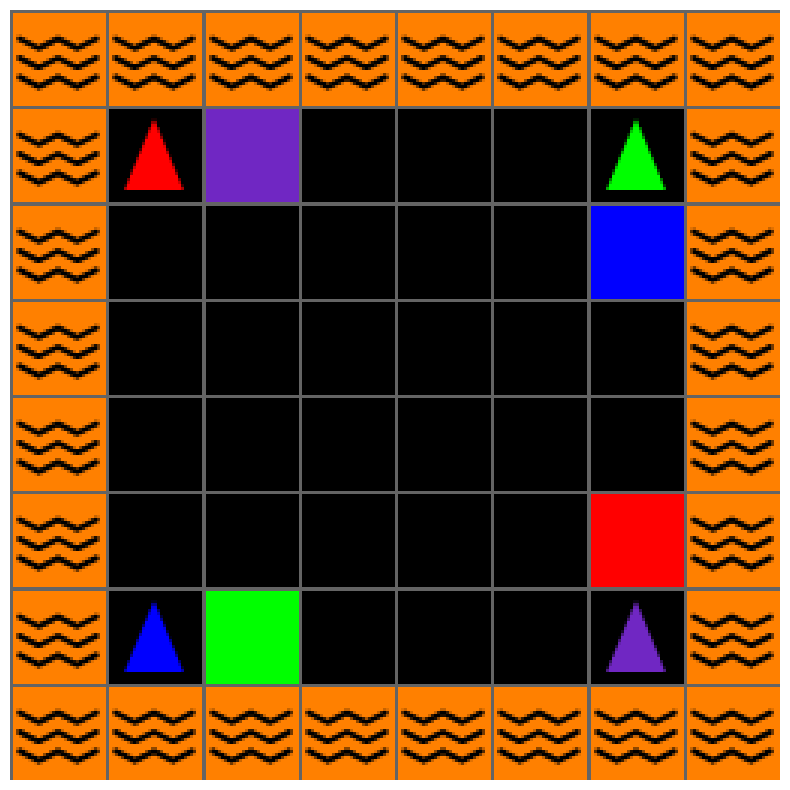

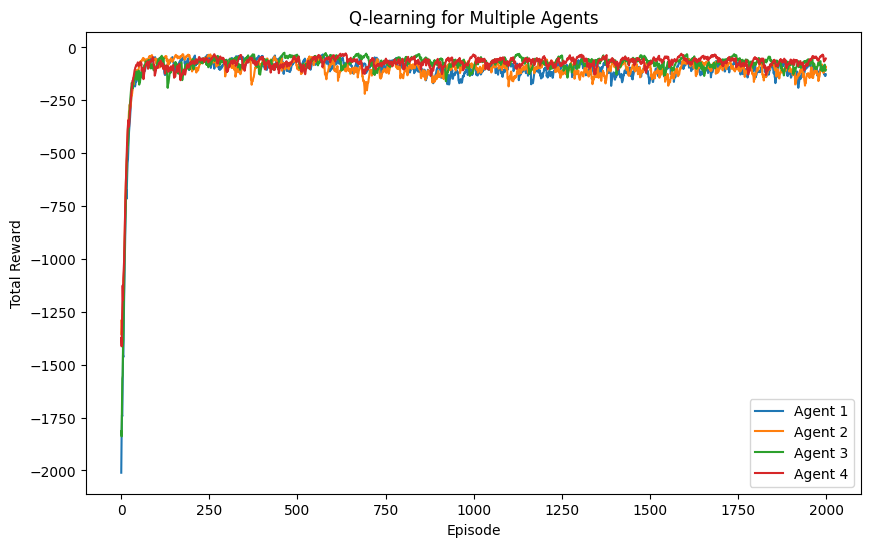

Plot saved as rewards.png


In [18]:
def generate_random_positions(num_agents, width=20, height=20, min_distance=4):
    """20
        height: Height of the grid
        min_distance: Minimum distance between any two agents/goals
        
    Returns:
        tuple: (agent_positions, goal_positions)
    """
    agent_positions = []
    goal_positions = []
    all_positions = []  # Track all positions (both agents and goals)
    
    # Helper function to check if a position is valid
    def is_valid_position(pos, existing_positions):
        x, y = pos
        
        # Check if within bounds (with margin to avoid edge positions)
        if x < 1 or x >= width-1 or y < 1 or y >= height-1:
            return False
        
        # Check minimum distance from all existing positions
        for ex_pos in existing_positions:
            dist = abs(ex_pos[0] - x) + abs(ex_pos[1] - y)  # Manhattan distance
            if dist < min_distance:
                return False
                
        return True
    
    # Generate agent positions
    for _ in range(num_agents):
        while True:
            # Random position within grid bounds
            pos = (random.randint(1, width-2), random.randint(1, height-2))
            
            if is_valid_position(pos, all_positions):
                agent_positions.append(pos)
                all_positions.append(pos)
                break
    
    # Generate goal positions
    for _ in range(num_agents):
        while True:
            # Random position within grid bounds
            pos = (random.randint(1, width-2), random.randint(1, height-2))
            
            if is_valid_position(pos, all_positions):
                goal_positions.append(pos)
                all_positions.append(pos)
                break
    
    return agent_positions, goal_positions


def create_and_pretrain_agents(
    num_agents=4, 
    width=9, 
    height=9, 
    training_episodes=2000, 
    max_training_steps=200,
    use_random_positions=False,
    random_min_distance=4,
    agent_positions=None,
    goal_positions=None,
    walls=None,
    visualize=True
):
    """
    Creates and trains agents with specified or randomly generated positions,
    then sets up a shared test environment.
    
    Args:
        num_agents: Number of agents to create
        width: Width of the grid environment
        height: Height of the grid environment
        training_episodes: Number of episodes for training each agent
        max_training_steps: Maximum number of steps per training episode
        use_random_positions: Whether to generate random positions
        random_min_distance: Minimum distance between random positions
        agent_positions: List of tuples with agent positions (ignored if use_random_positions=True)
        goal_positions: List of tuples with goal positions (ignored if use_random_positions=True)
        walls: List of tuples with wall positions
        
    Returns:
        tuple: (agents, train_env, test_env, Qstar)
    """
    print(f"\n===== Initializing environment with {num_agents} agents =====")
    
    # Generate positions if needed
    if use_random_positions:
        print(f"Generating random positions with minimum distance {random_min_distance}...")
        agent_positions, goal_positions = generate_random_positions(
            num_agents=num_agents, 
            width=width, 
            height=height, 
            min_distance=random_min_distance
        )
    else:
        # Use provided positions or defaults
        if agent_positions is None or goal_positions is None:
            print("Using default positions...")
            agent_positions = [(3,2),(2,3)] # Rotate to create cycle with +1 to x coordinate
            goal_positions = [(3,4),(4,3)] # Rotate to create cycle with +1 to x coordinate 
            
            # Truncate if too many for num_agents
            agent_positions = agent_positions[:num_agents]
            goal_positions = goal_positions[:num_agents]
            
            # Or extend with duplicates if not enough
            while len(agent_positions) < num_agents:
                agent_positions.append((1, 1))
            while len(goal_positions) < num_agents:
                goal_positions.append((width-2, height-2))
    
    # Set up walls if not specified
    if walls is None:
        walls = [(i, height // 2) for i in range(width // 3, 2 * width // 3)]
    
    print(f"Agent positions: {agent_positions}")
    print(f"Goal positions: {goal_positions}")
    print(f"Walls: {walls}")
    
    # Create training environment (separate environment for each agent)
    train_env = MultiAgentEnvWrapper(
        is_testing=False,
        width=width,
        height=height,
        agent_positions=agent_positions,
        goal_positions=goal_positions,
        walls=walls
    )
    
    # Create and train agents
    agents = []
    for i in range(len(agent_positions)):
        if visualize:
            print(f"\n===== Creating and training Agent {i+1} =====")
        agent = DynaQLearningAgent(state_dim=width*height, action_dim=5)
        agent.env_wrapper = train_env
        agent.agent_idx = i
        agents.append(agent)
    
    # Train all agents independently
    if visualize:
        print(f"\n===== Training Agents Independently =====")
    all_rewards = train_all_agents(train_env, agents, num_episodes=training_episodes, max_steps=max_training_steps)
    
   
    
    # Copy Q-tables from all agents to a shared Q-table dictionary
    Qstar = {}
    for i, agent in enumerate(agents):
        Qstar[i] = agent.q_table.copy()
    
    # Create test environment (shared environment with all agents)
    test_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=width,
        height=height,
        agent_positions=agent_positions,
        goal_positions=goal_positions,
        walls=walls
    )
    
    # Display the test environment
    if visualize:
        test_env.visualize()
        
        plot_rewards_for_all_agents(all_rewards)
    
    # Update agents to use the test environment
    for i, agent in enumerate(agents):
        agent.env_wrapper = test_env
    
    # Reset the environment
    obs, info = test_env.reset()
    
    
    return agents, train_env, test_env, Qstar

agent_positions = [(1,1),(1,6),(6,1),(6,6)] # Rotate to create cycle with +1 to x coordinate
goal_positions = [(6,5),(6,2),(2,6),(2,1)] # Rotate to create cycle with +1 to x coordinate

agents,train_env,test_env,Qstar=create_and_pretrain_agents(
    num_agents=5, 
    width=8, 
    height=8, 
    training_episodes=2000, 
    max_training_steps=200,
    use_random_positions=False,
    random_min_distance=2,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
)

### **Full Simulation and Safety Visualization Pipeline**

The `run_and_record_safety_pipeline` function runs a multi-agent simulation with safety-aware planning, while recording both:

* the environment evolution (main video),
* and each agent’s Q-table evolution (agent-specific videos).

**Key Features:**

* **Initial Setup:**

  * Creates output directories and filenames.
  * Resets the environment.
  * Initializes frame buffers for rendering both environment and Q-table visualizations.

* **Q-Table Visualization:**

  * For each agent, generates a static image showing its Q-table policy and unsafe states before the simulation starts.
  * Stores Q-table evolution visuals throughout the run for later video creation.

* **Path Visualization:**

  * Uses `visualize_all_agents_planned_paths` to generate a joint mask of k-step action plans.
  * These planned paths are used to highlight intentions of each agent in the visual output.

* **Safety-Aware Execution:**

  * At each step, actions are selected using `safety_aware_pipeline_with_safety_check`.
  * If a safety override is triggered, horizon-based Q-table figures are generated.
  * Otherwise, agents’ safe planned policies are visualized.
  * State transitions and decisions are rendered into the video frame buffer.

* **Video Export:**

  * Saves a video (`main_video`) of the full environment evolution with overlays showing paths and decisions.
  * Saves a second video (`qtable_video`) showing each agent’s Q-table and safety updates over time.

**Returns:**

* Path to the main video.
* Path to the Q-table video.
* Dictionary of Q-table snapshots per step (`Qsteps`) for further analysis.

In [ ]:
import numpy as np
from matplotlib.patches import Rectangle
import os

def run_and_visualize_unsafe_sets(test_env, agents, video_name="unsafe_sets_analysis.mp4", max_steps=30, 
                                 k=3, L=200, Qstars=None, handle_deadlocks=False, check_safety=True):
    """
    Runs the safety pipeline and tracks the unsafe sets at each step,
    then creates visualizations for each agent
    
    Args:
        test_env: The environment wrapper
        agents: List of agent objects
        video_name: Name for the output video
        max_steps: Maximum number of steps to simulate
        k: Safety lookahead parameter
        L: Learning iterations parameter
        Qstars: Optional reference Q-tables
        handle_deadlocks: Whether to handle deadlocks
        check_safety: Whether to check safety
        
    Returns:
        tuple: (unsafe_set_counts, unsafe_set_history, trajectories)
            - unsafe_set_counts: Dict mapping agent_idx to position counts in unsafe sets
            - unsafe_set_history: Dict mapping steps to unsafe sets for each agent
            - trajectories: Dict mapping agent_idx to list of positions
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    
    # Reset environment
    obs, info = test_env.reset()
    
    # Dictionary to store unsafe sets at each step for each agent
    unsafe_set_history = {}
    
    # Dictionary to count how many times each position appears in unsafe sets
    # Now keyed by agent index
    unsafe_set_counts = {i: {} for i in range(len(agents))}
    
    # Store initial agent positions
    initial_positions = [test_env.get_agent_position(idx=i) for i in range(len(agents))]
    
    # Track trajectories for each agent
    trajectories = {i: [initial_positions[i]] for i in range(len(agents))}
    number_of_steps=0
    
    # Get lava positions
    lava_positions = []
    if hasattr(test_env, 'lava_positions'):
        lava_positions = test_env.lava_positions
    
    # Run simulation for max_steps
    for step in range(max_steps):
        
        # Initialize the nested dictionaries properly for this step
        unsafe_set_history[step] = {}
        for horizon in range(1, k+1):
            unsafe_set_history[step][horizon] = {}
        
        # For each agent, compute and store the unsafe set
        for agent_idx in range(len(agents)):
            # Calculate n-step unsafe set
            for horizon in range(1, k+1):
                unsafe_set = K_agents_n_unsafe_set(test_env, agent_idx=agent_idx, n_steps=horizon, exclude_indices=None)
                unsafe_set_history[step][horizon][agent_idx] = unsafe_set
            
            # Update counts for each position in the unsafe set, now per agent
            # Exclude lava positions from counting
            for time_step, positions_with_counts in unsafe_set.items():
                for pos in positions_with_counts:
                    if pos not in lava_positions:  # Skip lava positions
                        if pos not in unsafe_set_counts[agent_idx]:
                            unsafe_set_counts[agent_idx][pos] = 0
                        unsafe_set_counts[agent_idx][pos] += 1
        
        # Execute one step using the safety pipeline
        actions, safety_status = safety_pipeline(
            test_env, agents, k=k, L=L, Qstar=Qstars,
            use_figures=False, handle_deadlocks=handle_deadlocks, check_safety=check_safety,
            collect_qsteps=False
        )
        if not test_env.all_agents_at_goals():
            number_of_steps+=1
        # Record new positions after step
        for agent_idx in range(len(agents)):
            trajectories[agent_idx].append(test_env.get_agent_position(idx=agent_idx))
        
        # Check if all agents reached their goals
        if test_env.all_agents_at_goals():
            print(f"All agents reached their goals in {step+1} steps!")
            break
    
    # Create results directory
    results_dir = os.path.expanduser("~/Desktop/Projet_MARL/safety_experiments")
    os.makedirs(results_dir, exist_ok=True)
    
    # Create one visualization per agent
    for agent_idx in range(len(agents)):
        # Create a new figure with a specific figure size
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Set up the grid
        width = test_env.width
        height = test_env.height
        ax.set_xlim(-0.5, width-0.5)
        ax.set_ylim(-0.5, height-0.5)
        ax.set_xticks(np.arange(-0.5, width, 1))
        ax.set_yticks(np.arange(-0.5, height, 1))
        ax.grid(color='black', linestyle='-', linewidth=1)
        
        # Add background color to all grid cells
        for x in range(width):
            for y in range(height):
                cell_color = 'white' if (x, y) in lava_positions else 'white'
                cell_alpha = 0.4 if (x, y) in lava_positions else 0.2
                ax.add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=True, color=cell_color, alpha=cell_alpha))
        
        # Find the maximum count for normalization (explicitly exclude lava cells)
        agent_counts = {pos: count for pos, count in unsafe_set_counts[agent_idx].items() 
                       if pos not in lava_positions}
        max_count = max(agent_counts.values()) if agent_counts else 1
        
        # Create a colormap for the unsafe frequencies
        cmap = plt.colormaps.get_cmap('Reds')  # Updated to fix the deprecation warning
        
        # Plot unsafe set frequencies for this agent
        for pos, count in agent_counts.items():
            x, y = pos
            if 0 <= x < width and 0 <= y < height:
                # Normalized color intensity based on frequency
                color_intensity = count / max_count
                ax.add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=True, 
                                      color=cmap(color_intensity), alpha=0.7))
                ax.text(x, y, f"{count}", ha='center', va='center', fontsize=9, color='black')
        
        # Plot agent trajectories
        for a_idx, path in trajectories.items():
            # Different colors and styles for each agent's trajectory
            color = 'blue' if a_idx == agent_idx else 'gray'
            alpha = 0.9 if a_idx == agent_idx else 0.4
            linewidth = 3 if a_idx == agent_idx else 1.5
            
            # Convert path to x and y coordinates for plotting
            x_coords, y_coords = zip(*path)
            
            # Plot the path line
            ax.plot(x_coords, y_coords, '-', color=color, linewidth=linewidth, alpha=alpha, 
                    marker='o', markersize=8, label=f"Agent {a_idx} Path")
            
            # Add step numbers along the path
            for i, (x, y) in enumerate(path):
                if a_idx == agent_idx or i == 0 or i == len(path)-1:  # Only show all steps for main agent
                    ax.text(x+0.3, y+0.3, f"{i}", fontsize=8, ha='center', va='center',
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='circle'))
        
        # Plot initial positions of all agents
        for a_idx, pos in enumerate(initial_positions):
            marker_color = 'blue' if a_idx == agent_idx else 'gray'
            marker_alpha = 0.8 if a_idx == agent_idx else 0.5
            ax.plot(pos[0], pos[1], 'o', markersize=15, color=marker_color, alpha=marker_alpha)
            ax.text(pos[0], pos[1], f"A{a_idx}", ha='center', va='center', color='white')
        
        # Plot goal positions for reference
        for a_idx in range(len(agents)):
            goal_pos = test_env.get_agent_goal(idx=a_idx)
            marker_color = 'green' if a_idx == agent_idx else 'lightgreen'
            marker_alpha = 0.8 if a_idx == agent_idx else 0.5
            ax.plot(goal_pos[0], goal_pos[1], '*', markersize=15, color=marker_color, alpha=marker_alpha)
            ax.text(goal_pos[0], goal_pos[1], f"G{a_idx}", ha='center', va='center', color='white')
        
        # Flip y-axis to match the environment's coordinates
        ax.set_ylim(ax.get_ylim()[::-1])
        
        # Add a colorbar to show frequency scale - now explicitly referencing the figure
        norm = colors.Normalize(vmin=0, vmax=max_count)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Frequency of appearance in unsafe sets (excluding lava)')
        
        # Add legend for the paths
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
        plt.title(f'Agent {agent_idx} Unsafe Set Frequency and Path (k={k}, {number_of_steps} steps)')
        plt.tight_layout()
        
        # Save the visualization
        fig_path = os.path.join(results_dir, f"agent{agent_idx}_unsafe_set_frequency_k{k}.png")
        plt.savefig(fig_path)
        
        print(f"Visualization for Agent {agent_idx} saved to: {fig_path}")
        plt.close(fig)  # Close the figure to free up memory
    
    return unsafe_set_counts, unsafe_set_history, trajectories

# Run the analysis with current environment and agents
unsafe_counts, unsafe_history, agent_trajectories = run_and_visualize_unsafe_sets(
    test_env, agents, max_steps=100, k=3, L=200, Qstars=Qstar,  # using the existing Qstar value
    handle_deadlocks=False, check_safety=False
)

All agents reached their goals in 10 steps!
Visualization for Agent 0 saved to: /home/yacine/Desktop/Projet_MARL/safety_experiments/agent0_unsafe_set_frequency_k3.png
Visualization for Agent 1 saved to: /home/yacine/Desktop/Projet_MARL/safety_experiments/agent1_unsafe_set_frequency_k3.png
Visualization for Agent 2 saved to: /home/yacine/Desktop/Projet_MARL/safety_experiments/agent2_unsafe_set_frequency_k3.png
Visualization for Agent 3 saved to: /home/yacine/Desktop/Projet_MARL/safety_experiments/agent3_unsafe_set_frequency_k3.png


In [ ]:
def run_and_record_safety_pipeline(test_env, agents, video_name="marl_simulation.mp4", max_steps=30, 
                                  k=3, L=200, Qstars=None, 
                                  use_figures=True, handle_deadlocks=False, check_safety=True,
                                  init_mode="Qstar", temporal_init_mode="Qstar", 
                                  deadlock_init_mode="Zeros",deadlock_protocole="Q",with_stay=True,
                                  collect_qsteps=True, epsilon=0.3):
    """Modified version that accepts safety pipeline parameters as arguments"""
    import os
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    
    # Create videos directory if it doesn't exist
    videos_dir = os.path.expanduser("~/Desktop/Projet_MARL/safety_experiments/videos")
    os.makedirs(videos_dir, exist_ok=True)
    
    # Full paths for video files
    main_video_path = os.path.join(videos_dir, video_name)
    qtable_video_name = "qtables_" + video_name
    qtable_video_path = os.path.join(videos_dir, qtable_video_name)
    
    # Reset environment
    obs, info = test_env.reset()
    
    # Initialize frame collections
    main_frames = []
    
    # Create a dictionary to store Q-table visualization frames for each agent
    qtable_frames = {i: [] for i in range(len(agents))}
    
    # Create initial Q-table visualizations for all agents
    for agent_idx in range(len(agents)):
        reachable_dict, reachable_set = compute_reachable_states(
            test_env, agent_idx=agent_idx, n_steps=5*k
        )
        unsafe_set_dict = K_agents_n_unsafe_set(
            test_env, agent_idx=agent_idx, n_steps=k, exclude_indices=None
        )
        
        fig = visualize_qtable_actions_with_unsafe_set(
            env=test_env,
            agent_idx=agent_idx,
            qtable=agents[agent_idx].q_table,
            reachable_set=reachable_set,
            unsafe_set_dict=unsafe_set_dict,
            show=False,
            title=f"Initial State - Agent {agent_idx+1}"
        )
        
        canvas = FigureCanvas(fig)
        canvas.draw()
        frame = np.array(canvas.renderer.buffer_rgba())
        qtable_frames[agent_idx].append(frame)
        plt.close(fig)
    
    # Add initial environment state to frames
    if Qstars is None:
        Qstar = {}
        for i, agent in enumerate(agents):
            Qstar[i] = agent.q_table.copy()
    else:
        Qstar = Qstars
        
    mask = visualize_all_agents_planned_paths(test_env, agents, k_steps=k, Qstar=Qstar)
    grid_img = test_env.visualize(show=False, highlight_masks=mask)
    
    # Create a title that includes all the flag settings
    flag_text = (
        f"Initial State | Configuration:\n"
        f"check_safety={check_safety}, handle_deadlocks={handle_deadlocks}\n"
        f"init_mode={init_mode}, temp_init={temporal_init_mode}, deadlock_init={deadlock_init_mode}"
    )
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img)
    plt.title(flag_text, fontsize=12)
    plt.axis('off')
    plt.tight_layout()
  
    canvas = FigureCanvas(plt.gcf())
    canvas.draw()
    initial_frame = np.array(canvas.renderer.buffer_rgba())
    plt.close()
    main_frames.append(initial_frame)
    
    Qsteps = {}
    
    # Run simulation with safety pipeline
    for step in range(max_steps):
        Qsteps[step] = {}
        for agent_idx in range(len(agents)):
            agent[agent_idx].q_table = Qstar[agent_idx].copy()
        # Run one step of the safety pipeline with the current configuration
        actions, safety_status, Qstep, step_figs = safety_pipeline(test_env, agents, k, L, epsilon=epsilon, Qstar=Qstar,
                   use_figures=use_figures, handle_deadlocks=handle_deadlocks, deadlock_protocole=deadlock_protocole, 
                   check_safety=check_safety, collect_qsteps=collect_qsteps, with_stay=with_stay, 
                   init_mode=init_mode, temporal_init_mode=temporal_init_mode, deadlock_init_mode=deadlock_init_mode)
        mask = visualize_all_agents_planned_paths(test_env, agents, k_steps=k, Qstar=Qstar)
        Qsteps[step] = Qstep
        
        # Process the figures for each agent
        for agent_idx in range(len(agents)):
            if agent_idx in step_figs and not safety_status[agent_idx]:
                # The agent needed safety intervention - use the horizon figures
                horizon_figs = step_figs[agent_idx]  # This should be a dict {k: fig, k-1: fig, ...}
                
                # Add each horizon's figure to the video
                sorted_horizons = sorted(horizon_figs.keys(), reverse=True)  # From k down to 1
                for horizon in sorted_horizons:
                    fig = horizon_figs[horizon]
                    canvas = FigureCanvas(fig)
                    canvas.draw()
                    frame = np.array(canvas.renderer.buffer_rgba())
                    qtable_frames[agent_idx].append(frame)
                    plt.close(fig)
            else:
                # The agent was already safe - create a new visualization
                reachable_dict, reachable_set = compute_reachable_states(
                    test_env, agent_idx=agent_idx, n_steps=k
                )
                unsafe_set_dict = K_agents_n_unsafe_set(
                    test_env, agent_idx=agent_idx, n_steps=k, exclude_indices=None
                )
                
                fig = visualize_qtable_actions_with_unsafe_set(
                    env=test_env,
                    agent_idx=agent_idx,
                    qtable=Qstar[agent_idx],
                    reachable_set=reachable_set,
                    unsafe_set_dict=unsafe_set_dict,
                    show=False,
                    title=f"Step {step+1} - Agent {agent_idx+1} (Safe) - Action: {actions[agent_idx]}"
                )
                
                canvas = FigureCanvas(fig)
                canvas.draw()
                frame = np.array(canvas.renderer.buffer_rgba())
                qtable_frames[agent_idx].append(frame)
                plt.close(fig)
        
        # Create the main environment visualization
        grid_img = test_env.visualize(highlight_masks=mask, show=False)
        
        # Create a step title that includes all the flag settings
        step_flag_text = (
            f"Step {step+1} | Actions: {actions} | Safety: {safety_status}\n"
            f"check_safety={check_safety}, handle_deadlocks={handle_deadlocks}\n"
            f"init_mode={init_mode}, temp_init={temporal_init_mode}, deadlock_init={deadlock_init_mode}"
        )
        
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img)
        plt.title(step_flag_text, fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        frame = np.array(canvas.renderer.buffer_rgba())
        plt.close()
        main_frames.append(frame)
        
        print(f"Actions taken: {actions}")
        
        # Check if simulation is complete
        done = test_env.all_agents_at_goals()
        if done:
            print(f"All agents reached their goals in {step+1} steps!")
            
            grid_img = test_env.visualize(show=False)
            
            # Create a success title that includes all the flag settings
            success_flag_text = (
                f"Success! All agents reached goals in {step+1} steps\n"
                f"check_safety={check_safety}, handle_deadlocks={handle_deadlocks}\n"
                f"init_mode={init_mode}, temp_init={temporal_init_mode}, deadlock_init={deadlock_init_mode}"
            )
            
            plt.figure(figsize=(10, 10))
            plt.imshow(grid_img)
            plt.title(success_flag_text, fontsize=16, color='green')
            plt.axis('off')
            plt.tight_layout()
            
            canvas = FigureCanvas(plt.gcf())
            canvas.draw()
            success_frame = np.array(canvas.renderer.buffer_rgba())
            plt.close()
            main_frames.append(success_frame)
            break
    
    # Create the main video
    height, width, _ = main_frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    main_video = cv2.VideoWriter(main_video_path, fourcc, 2, (width, height))
    
    for frame in main_frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        main_video.write(frame_bgr)
    
    main_video.release()
    print(f"Main video saved to: {main_video_path}")
    
    # Create the Q-table video with agent-by-agent progression
    if any(frames for frames in qtable_frames.values()):
        sample_frame = next(frame for frames in qtable_frames.values() for frame in frames if len(frames) > 0)
        q_height, q_width, _ = sample_frame.shape
        
        qtable_video = cv2.VideoWriter(qtable_video_path, fourcc, 1, (q_width, q_height))
        
        # Create title frame with flag information
        plt.figure(figsize=(12, 10))
        plt.text(0.5, 0.5, 
                f"Q-Table Evolution by Agent\nConfiguration:\n"
                f"check_safety={check_safety}, handle_deadlocks={handle_deadlocks}\n"
                f"init_mode={init_mode}, temp_init={temporal_init_mode}, deadlock_init={deadlock_init_mode}",
                ha="center", va="center", fontsize=18, fontweight="bold")
        plt.axis("off")
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        title_frame = np.array(canvas.renderer.buffer_rgba())
        title_frame_bgr = cv2.cvtColor(title_frame, cv2.COLOR_RGBA2BGR)
        title_frame_resized = cv2.resize(title_frame_bgr, (q_width, q_height))
        plt.close()
        
        # Add title frame to video (2 seconds)
        for _ in range(2):
            qtable_video.write(title_frame_resized)
        
        # For each agent, add their Q-table frames
        for agent_idx in range(len(agents)):
            if len(qtable_frames[agent_idx]) > 0:
                # Add agent title slide
                plt.figure(figsize=(12, 10))
                plt.text(0.5, 0.5, f"Agent {agent_idx+1} Q-Table Evolution", 
                        ha="center", va="center", fontsize=24, fontweight="bold")
                plt.axis("off")
                canvas = FigureCanvas(plt.gcf())
                canvas.draw()
                agent_title = np.array(canvas.renderer.buffer_rgba())
                agent_title_bgr = cv2.cvtColor(agent_title, cv2.COLOR_RGBA2BGR)
                agent_title_resized = cv2.resize(agent_title_bgr, (q_width, q_height))
                plt.close()
                
                # Add agent title to video (2 seconds)
                for _ in range(2):
                    qtable_video.write(agent_title_resized)
                
                # Add all frames for this agent
                for frame in qtable_frames[agent_idx]:
                    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
                    qtable_video.write(frame_bgr)
                
                # Add a separator frame if not the last agent
                if agent_idx < len(agents) - 1:
                    separator = np.ones((q_height, q_width, 3), dtype=np.uint8) * 255
                    qtable_video.write(separator)
        
        qtable_video.release()
        print(f"Q-table video saved to: {qtable_video_path}")
    
    return main_video_path, qtable_video_path, Qsteps
run_and_record_safety_pipeline(
    test_env, agents, video_name="marl_simulation.mp4", max_steps=30, 
    k=2, L=200, Qstars=Qstar,  # using the existing Qstar value
    use_figures=True, handle_deadlocks=True, check_safety=False,
    init_mode="Qstar", temporal_init_mode="Qstar", deadlock_init_mode="Zeros",deadlock_protocole="Q",with_stay=False,
    collect_qsteps=True, epsilon=0.3
)

Planned path for Agent 1: [(1, 1), (np.int64(2), np.int64(1)), (np.int64(3), np.int64(1))]
Planned path for Agent 2: [(1, 6), (np.int64(2), np.int64(6)), (np.int64(3), np.int64(6))]
Planned path for Agent 3: [(6, 1), (np.int64(5), np.int64(1)), (np.int64(4), np.int64(1))]
Planned path for Agent 4: [(6, 6), (np.int64(5), np.int64(6)), (np.int64(4), np.int64(6))]
Planned path for Agent 1: [(1, 2), (np.int64(2), np.int64(2)), (np.int64(3), np.int64(2))]
Planned path for Agent 2: [(1, 5), (np.int64(2), np.int64(5)), (np.int64(3), np.int64(5))]
Planned path for Agent 3: [(6, 2), (np.int64(5), np.int64(2)), (np.int64(4), np.int64(2))]
Planned path for Agent 4: [(6, 5), (np.int64(5), np.int64(5)), (np.int64(4), np.int64(5))]
Actions taken: [np.int64(4), np.int64(3), np.int64(4), np.int64(3)]
Planned path for Agent 1: [(2, 2), (np.int64(3), np.int64(2)), (np.int64(4), np.int64(2))]
Planned path for Agent 2: [(2, 5), (np.int64(3), np.int64(5)), (np.int64(4), np.int64(5))]
Planned path for Agent

('/home/yacine/Desktop/Projet_MARL/safety_experiments/videos/marl_simulation.mp4',
 '/home/yacine/Desktop/Projet_MARL/safety_experiments/videos/qtables_marl_simulation.mp4',
 {0: {0: {2: {(np.int64(0),
      np.int64(1)): array([-500.3183402 ,   -1.21626553,   -8.64827525, -537.56840262,
            -505.95757929]),
     (np.int64(1),
      np.int64(2)): array([  -7.72553056, -506.4157579 ,   -6.81199499,   -8.64827525,
              -6.79346521]),
     (np.int64(2),
      np.int64(1)): array([  -7.73809821,   -8.64827525,   -6.97572398, -502.12891932,
              -6.81136272]),
     (np.int64(1),
      np.int64(0)): array([-500.6117564 , -537.70433136, -501.28008515,   -1.14189182,
              -8.64827525]),
     (1,
      1): array([  -8.64827525, -501.8000869 ,   -7.73645594, -501.76889269,
              -7.72553056])},
    1: {(np.int64(0),
      np.int64(1)): array([-501.20392581,   -1.00003444,   -8.64827525, -516.88680655,
            -507.64800598]),
     (np.int64(1),
    

## Experiments
The function `run_multiple_safety_experiments` runs a series of experiments using different combinations of flags while keeping certain parameters like `k` (planning horizon) and `L` (learning iterations) fixed. Here's a breakdown of the flags and their meanings:

### **Flags and their configurations:**

1. **`handle_deadlocks`**:

   * **True**: Deadlock handling is enabled (Apply deadlock protocole).
   * **False**: Deadlock handling is disabled. Agents can get stuck if a deadlock occurs.

2. **`check_safety`**:

   * **True**: Safety checks are enabled update the Qtable only when an unsafe action occurs in n_step.
   * **False**: Always update Qtable .

3. **`init_mode`**:

   * **`"Qstar"`**: The agents' Q-tables will be initialized using a reference Q-table (`Qstar`).
   * **`"Zeros"`**: The agents' Q-tables will be initialized with zeros.

4. **`temporal_init_mode`**:

   * **`"Qt_plus_1"`**: The agents' Q-tables will be initialized based on the next temporal value (`Qt_plus_1`).
   * **`"Qstar"`**: The Q-tables will be initialized using the `Qstar` reference.
   * **`"Zeros"`**: The Q-tables will be initialized with zeros.

5. **`deadlock_init_mode`**:

   * **`"Qstar"`**: If a deadlock occurs, the Q-table will be initialized using the reference Q-table (`Qstar`).
   * **`"Qt_plus_1"`**: If a deadlock occurs, the Q-table will be initialized with the next temporal value (`Qt_plus_1`).
   * **`"Zeros"`**: If a deadlock occurs, the Q-table will be initialized with zeros.

### **Function: `run_all_safety_flag_combinations`**:

This function:

* Initializes the agents' Q-tables.
* Calls `run_multiple_safety_experiments` to run all experiments with the given parameters (`k=3` and `L=500` by default).
* After all experiments have run, it prints a summary of the results, including the number of successful and failed experiments.


In [ ]:
def run_multiple_safety_experiments(test_env, agents, base_name="safety_exp", 
                                   max_steps=30, k=3, L=500, 
                                   Qstars=None):
    """
    Run multiple experiments with the safety pipeline using different flag combinations
    while keeping the same k and L values.
    
    Args:
        test_env: The environment to run simulations in
        agents: List of agents to use
        base_name: Base name for the output files
        max_steps: Maximum steps for each simulation
        k: Planning horizon parameter
        L: Learning iterations parameter
        safety_threshold: Safety threshold parameter
        Qstars: Optional dictionary of reference Q-tables for agents
    
    Returns:
        dict: Results for each experiment configuration
    """
    import time
    import os
    import pandas as pd
    import cv2
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    from itertools import product
    
    # Directory for saving results
    results_dir = os.path.expanduser("~/Desktop/Projet_MARL/safety_experiments")
    os.makedirs(results_dir, exist_ok=True)
    
    # Define all flag combinations to test
    safety_flags = {
        'use_figures': [True],  # Always True as requested
        'handle_deadlocks': [True],
        'check_safety': [True,False],
        'init_mode': ["Qstar"],
        'temporal_init_mode': ["Qstar"],
        'deadlock_init_mode': ["Zeros"],
        'deadlock_protocole': ["Q", "random"],
        'with_stay': [True, False],
    }
    
    # Generate all possible combinations of flags
    flag_keys = list(safety_flags.keys())
    flag_values = list(safety_flags.values())
    all_combinations = list(product(*flag_values))
    
    print(f"Testing {len(all_combinations)} flag combinations")
    
    # To store results from all experiments
    all_results = {}
    all_qtable_data = []
    
    # Extract environment parameters from the test_env
    width = test_env.width
    height = test_env.height
    
    # Get the agent and goal positions from the test environment
    agent_positions = [test_env.get_agent_position(idx=i) for i in range(len(agents))]
    goal_positions = [test_env.get_agent_goal(idx=i) for i in range(len(agents))]
    
    # Get walls (assuming we can extract them)
    # This is a placeholder - you might need to adapt this to your environment
    walls = [(i, height // 2) for i in range(width // 3, 2 * width // 3)]
    
    # Run each experiment with a specific flag combination
    for config_idx, config_values in enumerate(all_combinations):
        # Create config dictionary from keys and values
        config = dict(zip(flag_keys, config_values))
        
        print(f"\n\n===== Running Experiment {config_idx+1}/{len(all_combinations)} =====")
        print(f"Configuration: {config}")
        
        # Create a unique name for this configuration
        config_name = f"{base_name}_k{k}_L{L}"
        for flag, value in config.items():
            if isinstance(value, bool):
                config_name += f"_{flag[:4]}{'T' if value else 'F'}" 
            else:
                config_name += f"_{flag[:4]}{value[:2]}"
        
        video_name = f"{config_name}.mp4"
        print(f"Running with video name: {video_name}")
        
        # Retrain agents before each experiment
        print("\n----- Retraining agents for this configuration -----")
        new_agents, train_env, new_test_env, new_Qstars = create_and_pretrain_agents(
            num_agents=len(agents),
            width=width,
            height=height,
            training_episodes=1000,  # Reduced episodes for faster training
            max_training_steps=200,
            use_random_positions=False,
            agent_positions=agent_positions,
            goal_positions=goal_positions,
            walls=walls,
            visualize=False
        )
        
        # Run the experiment with the fresh agents and environment
        start_time = time.time()
        try:
            main_video_path, qtable_video_path, experiment_qsteps = run_and_record_safety_pipeline(
                test_env=new_test_env, 
                agents=new_agents, 
                video_name=video_name,
                max_steps=max_steps,
                k=k,
                L=L,
                Qstars=new_Qstars,
                use_figures=config['use_figures'],
                handle_deadlocks=config['handle_deadlocks'],
                check_safety=config['check_safety'],
                init_mode=config['init_mode'],
                temporal_init_mode=config['temporal_init_mode'],
                deadlock_init_mode=config['deadlock_init_mode']
                , deadlock_protocole=config['deadlock_protocole'],
                with_stay=config['with_stay'],
            )
            
            # Flatten Q-table data for CSV and append configuration info
            for step, agent_data in experiment_qsteps.items():
                for agent_idx, horizon_data in agent_data.items():
                    for horizon, qtable in horizon_data.items():
                        for state, qvalues in qtable.items():
                            row = {
                                'experiment': config_idx,
                                'video_name': video_name,
                                'step': step,
                                'agent': agent_idx,
                                'horizon': horizon,
                                'state': str(state),
                                'qvalues': str(qvalues.tolist()),
                                'best_action': np.argmax(qvalues)
                            }
                            # Add configuration flags
                            for flag, value in config.items():
                                row[flag] = value
                            
                            all_qtable_data.append(row)
            
            # Store experiment results
            all_results[config_idx] = {
                'config': config,
                'video_name': video_name,
                'main_video': main_video_path,
                'qtable_video': qtable_video_path,
                'duration': time.time() - start_time,
                'number_of_steps': len(experiment_qsteps),
            }
            
            print(f"Experiment completed in {time.time() - start_time:.2f} seconds")
            
        except Exception as e:
            print(f"Error in experiment {config_idx}: {e}")
            all_results[config_idx] = {
                'config': config,
                'error': str(e)
            }
    
    # Save all Q-table data to CSV
    csv_path = os.path.join(results_dir, f"{base_name}_k{k}_L{L}_all_qtables.csv")
    pd.DataFrame(all_qtable_data).to_csv(csv_path, index=False)
    print(f"\nAll Q-table data saved to: {csv_path}")
    
    # Save experiment summary
    summary_data = []
    for exp_idx, result in all_results.items():
        row = {'experiment': exp_idx}
        row.update(result.get('config', {}))
        if 'error' not in result:
            row.update({
                'video_name': result['video_name'],
                'duration': result['duration'],
                'number_of_steps': result['number_of_steps'],
            })
        else:
            row['error'] = result['error']
        summary_data.append(row)
    
    summary_path = os.path.join(results_dir, f"{base_name}_k{k}_L{L}_summary.csv")
    pd.DataFrame(summary_data).to_csv(summary_path, index=False)
    print(f"Experiment summary saved to: {summary_path}")
    
    return all_results

# Execute the experiments
def run_all_safety_flag_combinations(test_env, agents, k=3, L=500):
    """
    Main function to run all safety flag combinations and analyze the results
    """
    import time
    
    # Make sure we have valid Qstar values
    Qstar = {}
    for i, agent in enumerate(agents):
        Qstar[i] = agent.q_table.copy()
    
    # Run all experiments with the specified k and L values
    print(f"\n===== Starting all safety flag experiments with k={k}, L={L} =====")
    start_time = time.time()
    
    experiment_results = run_multiple_safety_experiments(
        test_env=test_env, 
        agents=agents,
        base_name=f"safety_full_comparison",
        max_steps=30,
        k=k,
        L=L,
        Qstars=Qstar
    )
    
    total_time = time.time() - start_time
    print(f"\n===== All experiments completed in {total_time:.2f} seconds =====")
    
    # Print summary of results
    successful_exps = 0
    failed_exps = 0
    
    for exp_idx, result in experiment_results.items():
        if 'error' not in result:
            print(f"Experiment {exp_idx}: {result['video_name']} - Duration: {result['duration']:.2f}s")
            successful_exps += 1
        else:
            print(f"Experiment {exp_idx}: FAILED - {result['error']}")
            failed_exps += 1
    
    print(f"\nTotal experiments: {len(experiment_results)}")
    print(f"Successful: {successful_exps}")
    print(f"Failed: {failed_exps}")
    
    return experiment_results

run_all_safety_flag_combinations(test_env, agents, k=3, L=500)


===== Starting all safety flag experiments with k=3, L=500, 50 repetitions =====
Testing 4 flag combinations, 50 times each


===== Running Experiment 1/4 =====
Configuration: {'use_figures': True, 'handle_deadlocks': True, 'check_safety': True, 'init_mode': 'Qstar', 'temporal_init_mode': 'Qstar', 'deadlock_init_mode': 'Zeros', 'deadlock_protocole': 'Q', 'with_stay': True}

----- Running repetition 1/50 -----

===== Initializing environment with 4 agents =====
Agent positions: [(1, 1), (1, 6), (6, 1), (6, 6)]
Goal positions: [(6, 5), (6, 2), (2, 6), (2, 1)]
Walls: [(2, 4), (3, 4), (4, 4)]

Training Agent 1...
Episode 0, Agent 1
Episode 0, Total Reward for Agent 1: -1521.0
Episode 10, Agent 1
Episode 10, Total Reward for Agent 1: -894.0
Episode 20, Agent 1
Episode 20, Total Reward for Agent 1: -10.0
Episode 30, Agent 1
Episode 30, Total Reward for Agent 1: -13.0
Episode 40, Agent 1
Episode 40, Total Reward for Agent 1: -15.0
Episode 50, Agent 1
Episode 50, Total Reward for Agent 1: -8.

KeyboardInterrupt: 

Testing 8 flag combinations, 25 runs each

===== Configuration 1/8 =====
Configuration: {'handle_deadlocks': True, 'check_safety': True, 'deadlock_protocole': 'Q', 'with_stay': True, 'use_figures': True, 'init_mode': 'Qstar', 'temporal_init_mode': 'Qstar', 'deadlock_init_mode': 'Zeros', 'collect_qsteps': False}
  Run 1/25

===== Initializing environment with 4 agents =====
Agent positions: [(1, 1), (1, 6), (6, 1), (6, 6)]
Goal positions: [(6, 5), (6, 2), (2, 6), (2, 1)]
Walls: [(2, 4), (3, 4), (4, 4)]

Training Agent 1...
Episode 0, Agent 1
Episode 0, Total Reward for Agent 1: -1766.0
Episode 10, Agent 1
Episode 10, Total Reward for Agent 1: -211.0
Episode 20, Agent 1
Episode 20, Total Reward for Agent 1: -476.0
Episode 30, Agent 1
Episode 30, Total Reward for Agent 1: -9.0
Episode 40, Agent 1
Episode 40, Total Reward for Agent 1: -13.0
Episode 50, Agent 1
Episode 50, Total Reward for Agent 1: -163.0
Episode 60, Agent 1
Episode 60, Total Reward for Agent 1: -117.0
Episode 70, Agent 1
E

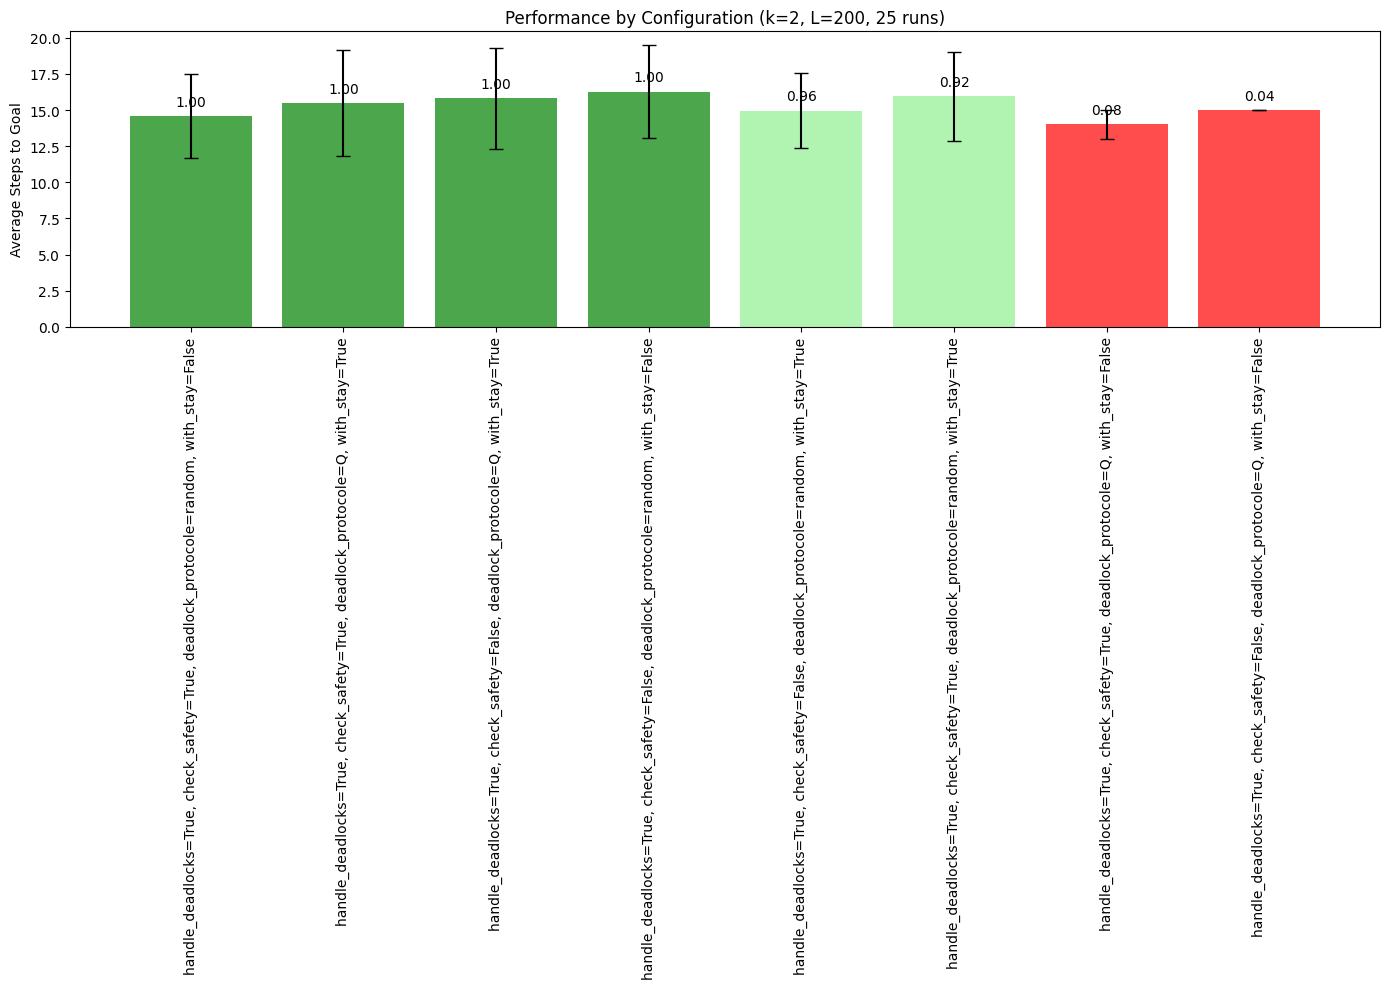

In [19]:
import time
import os
import pandas as pd
import numpy as np
from itertools import product
from tqdm.notebook import tqdm

def run_statistical_safety_experiments(test_env, agents, n_runs=5, max_steps=30, k=3, L=200):
    """
    Runs multiple safety experiments for each flag configuration and computes average statistics.
    
    Args:
        test_env: The environment to run simulations in
        agents: List of agents to use
        n_runs: Number of runs per configuration
        max_steps: Maximum steps for each simulation
        k: Planning horizon parameter
        L: Learning iterations parameter
        
    Returns:
        pd.DataFrame: Summary statistics for each configuration
    """
    import matplotlib.pyplot as plt
    
    # Define all flag combinations to test
    safety_flags = {
        'handle_deadlocks': [ True],
        'check_safety': [ True, False],
        'deadlock_protocole': ["Q", "random"],
        'with_stay': [True, False],
    }
    
    # Fixed flags
    fixed_flags = {
        'use_figures': True,
        'init_mode': "Qstar",
        'temporal_init_mode': "Qstar",
        'deadlock_init_mode': "Zeros",
        'collect_qsteps': False  # Don't need to collect q-steps for stats
    }
    
    # Generate all possible combinations of flags
    flag_keys = list(safety_flags.keys())
    flag_values = list(safety_flags.values())
    all_combinations = list(product(*flag_values))
    
    print(f"Testing {len(all_combinations)} flag combinations, {n_runs} runs each")
    
    # Directory for saving results
    results_dir = os.path.expanduser("~/Desktop/Projet_MARL/safety_experiments_updated")
    os.makedirs(results_dir, exist_ok=True)
    
    # Extract environment parameters from the test_env
    width = test_env.width
    height = test_env.height
    agent_positions = [test_env.get_agent_position(idx=i) for i in range(len(agents))]
    goal_positions = [test_env.get_agent_goal(idx=i) for i in range(len(agents))]
    walls = [(i, height // 2) for i in range(width // 3, 2 * width // 3)]
    
    # To store results from all experiments
    results = []
    
    # Run each experiment with a specific flag combination
    for config_idx, config_values in enumerate(all_combinations):
        # Create config dictionary from keys and values
        config = dict(zip(flag_keys, config_values))
        config.update(fixed_flags)  # Add fixed flags
        
        print(f"\n===== Configuration {config_idx+1}/{len(all_combinations)} =====")
        print(f"Configuration: {config}")
        
        # Create a unique name for this configuration
        config_str = ", ".join(f"{k}={v}" for k, v in config.items() 
                              if k not in fixed_flags or k == 'check_safety' or k == 'handle_deadlocks')
        
        # Statistics for this configuration
        steps_list = []
        success_count = 0
        failure_count = 0
        deadlock_count = 0
        timeout_count = 0
        
        # Run multiple times for statistical significance
        for run in range(n_runs):
            print(f"  Run {run+1}/{n_runs}")
            
            # Create fresh agents and environment for this run
            new_agents, train_env, new_test_env, new_Qstars = create_and_pretrain_agents(
                num_agents=len(agents),
                width=width,
                height=height,
                training_episodes=1000,
                max_training_steps=200,
                use_random_positions=False,
                agent_positions=agent_positions,
                goal_positions=goal_positions,
                walls=walls,
                visualize=False
            )
            
            # Reset environment
            new_test_env.reset()
            
            # Count the steps needed
            step_count = 0
            reached_goal = False
            
            # Run simulation until goal is reached or max_steps is hit
            for step in range(max_steps):
                # Run one step of the safety pipeline
                for agent_idx in range(len(new_agents)):
                    new_Qstars[agent_idx] = new_agents[agent_idx].q_table.copy()
                try:
                    actions, safety_status = safety_pipeline(
                        new_test_env, new_agents, k=k, L=L, epsilon=0.3, Qstar=new_Qstars,
                        use_figures=False, 
                        handle_deadlocks=config['handle_deadlocks'],
                        check_safety=config['check_safety'],
                        collect_qsteps=False,
                        deadlock_protocole=config['deadlock_protocole'],
                        with_stay=config['with_stay']
                    )
                    
                    step_count += 1
                    
                    # Check if agents have reached goals
                    if new_test_env.all_agents_at_goals():
                        reached_goal = True
                        success_count += 1
                        break
                        
                    # Check for deadlock (all agents choosing action 0)
                    if all(action == 0 for action in actions):
                        deadlock_count += 1
                        break
                        
                except Exception as e:
                    print(f"Error in run {run+1}: {e}")
                    failure_count += 1
                    break
            
            if not reached_goal:
                if step_count >= max_steps:
                    timeout_count += 1
                
            # Record steps (only for successful runs)
            if reached_goal:
                steps_list.append(step_count)
        
        # Calculate statistics
        avg_steps = np.mean(steps_list) if steps_list else np.nan
        std_steps = np.std(steps_list) if len(steps_list) > 1 else 0
        success_rate = success_count / n_runs
        
        # Store results for this configuration
        result = {
            'config_idx': config_idx,
            'config_str': config_str,
            'handle_deadlocks': config['handle_deadlocks'],
            'check_safety': config['check_safety'],
            'deadlock_protocole': config['deadlock_protocole'],
            'with_stay': config['with_stay'],
            'avg_steps': avg_steps,
            'std_steps': std_steps,
            'success_rate': success_rate,
            'success_count': success_count,
            'failure_count': failure_count,
            'deadlock_count': deadlock_count,
            'timeout_count': timeout_count
        }
        
        results.append(result)
        
        print(f"Config: {config_str}")
        print(f"Success rate: {success_rate:.2f} ({success_count}/{n_runs})")
        if steps_list:
            print(f"Average steps: {avg_steps:.2f} ± {std_steps:.2f}")
        else:
            print("Average steps: N/A (no successful runs)")
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Save results
    csv_path = os.path.join(results_dir, f"safety_stats_k{k}_L{L}_runs{n_runs}.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")
    
    # Plot results
    plt.figure(figsize=(14, 10))
    
    # Sort by success rate and average steps
    plot_df = results_df.sort_values(['success_rate', 'avg_steps'], ascending=[False, True])
    
    # Create bar chart with error bars
    bars = plt.bar(
        x=range(len(plot_df)),
        height=plot_df['avg_steps'],
        yerr=plot_df['std_steps'],
        capsize=5,
        color=[
            'green' if sr == 1.0 else 
            'lightgreen' if sr >= 0.75 else 
            'yellow' if sr >= 0.5 else 
            'orange' if sr >= 0.25 else 
            'red' 
            for sr in plot_df['success_rate']
        ],
        alpha=0.7
    )
    
    plt.xticks(range(len(plot_df)), plot_df['config_str'], rotation=90)
    plt.ylabel('Average Steps to Goal')
    plt.title(f'Performance by Configuration (k={k}, L={L}, {n_runs} runs)')
    
    # Add success rate as text on each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if not np.isnan(height):
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.5,
                f"{plot_df.iloc[i]['success_rate']:.2f}",
                ha='center', va='bottom', rotation=0
            )
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f"safety_stats_k{k}_L{L}_runs{n_runs}_no.png"))
    plt.show()
    
    return results_df

stats_df = run_statistical_safety_experiments(test_env, agents, n_runs=25, max_steps=50, k=2, L=200)

### **Q-table Analysis (Data Analysis)**

This block runs simulations for different values of `k` and `L`, flattens the Q-tables at each step into structured rows, and saves them as CSV files.

The goal is purely analytical: to study how Q-values evolve over time based on the planning parameters (`k`, `L`).


In [ ]:

def flatten_qsteps(qsteps, k_value=None, L_value=None):
    """
    Aplatit la structure hiérarchique de Qsteps en lignes pour DataFrame,
    en déterminant automatiquement quelle position est le centre (agent) 
    et quelles positions sont up, down, left, right.
    
    Args:
        qsteps: Le dictionnaire hiérarchique à aplatir
        k_value: La valeur de k (horizon maximum) utilisée
        L_value: La valeur de L (itérations) utilisée
    
    Returns:
        list: Liste de dictionnaires, chaque dictionnaire représentant une ligne
    """
    rows = []
    
    for step, agents_dict in qsteps.items():
        if not agents_dict:  # Skip empty dictionaries
            continue
            
        for agent_idx, horizons_dict in agents_dict.items():
            if not horizons_dict:  # Skip empty dictionaries
                continue
                
            # Trier les horizons dans l'ordre croissant
            sorted_horizons = sorted(horizons_dict.keys(), reverse=False)
            
            for horizon in sorted_horizons:
                qtable = horizons_dict[horizon]
                if not qtable or len(qtable) == 0:  # Skip empty dictionaries
                    continue
                
                # Convertir tous les états en tuples d'entiers simples
                states = []
                for state in qtable.keys():
                    clean_state = tuple(int(x) for x in state)
                    states.append(clean_state)
                
                if len(states) == 0:
                    continue
                    
                # Trouver la position de l'agent (centre) et les positions adjacentes
                # On suppose que le centre est la position qui a des voisins dans les 4 directions
                positions = {'center': None, 'up': None, 'down': None, 'left': None, 'right': None}
                
                # Si nous avons exactement 5 états, nous pouvons déterminer directement le centre
                if len(states) == 5:
                    # Pour chaque état potentiel au centre
                    for state in states:
                        # Vérifier si les 4 directions adjacentes sont présentes
                        up = (state[0], state[1] - 1)
                        down = (state[0], state[1] + 1)
                        left = (state[0] - 1, state[1])
                        right = (state[0] + 1, state[1])
                        
                        if up in states and down in states and left in states and right in states:
                            positions['center'] = state
                            positions['up'] = up
                            positions['down'] = down
                            positions['left'] = left
                            positions['right'] = right
                            break
                
                # Si nous n'avons pas trouvé le centre avec la méthode précédente
                # Cela peut arriver si certains états sont bloqués par des murs
                if positions['center'] is None and len(states) > 0:
                    # Alternative: trouver le "centre" comme étant l'état avec le plus de voisins
                    neighbor_counts = {}
                    for state in states:
                        neighbors = [
                            (state[0], state[1] - 1),  # up
                            (state[0], state[1] + 1),  # down
                            (state[0] - 1, state[1]),  # left
                            (state[0] + 1, state[1])   # right
                        ]
                        count = sum(1 for n in neighbors if n in states)
                        neighbor_counts[state] = count
                    
                    # L'état avec le plus de voisins est probablement le centre
                    center = max(neighbor_counts.items(), key=lambda x: x[1])[0]
                    positions['center'] = center
                    
                    # Déterminer les positions adjacentes présentes
                    up = (center[0], center[1] - 1)
                    down = (center[0], center[1] + 1)
                    left = (center[0] - 1, center[1])
                    right = (center[0] + 1, center[1])
                    
                    positions['up'] = up if up in states else None
                    positions['down'] = down if down in states else None
                    positions['left'] = left if left in states else None
                    positions['right'] = right if right in states else None
                
                # Créer une ligne pour cette configuration
                row = {
                    'k': k_value,
                    'L': L_value,
                    'Step': step,
                    'Agent': agent_idx,
                    'Horizon': "original qtable" if horizon == k_value + 1 else horizon,
                }
                
                # Ajouter le s états et leurs valeurs Q
                for pos_name, pos in positions.items():
                    if pos is not None:
                        row[f'{pos_name}_Position'] = pos
                        q_values = qtable[pos]
                        row[f'{pos_name}_Q'] = q_values
                        row[f'{pos_name}_BestAction'] = np.argmax(q_values)
                
                rows.append(row)
    
    return rows
# Définir les plages de valeurs pour L et k
L_values = [1,5,10 ,15,20,50,100,200]
k_values = [1,2,3]safety_threshold=-2.0, 

# Créer un dossier pour les résultats si nécessaire
results_dir = os.path.expanduser("~/Desktop/Projet_MARL/toy_exeemple_normalized")
os.makedirs(results_dir, exist_ok=True)

# Liste pour collecter toutes les données pour CSV
all_rows = []

# Exécuter la simulation pour chaque combinaison de paramètres
for k, L in product(k_values, L_values):
    print(f"\n\n===== Running with k={k}, L={L} =====")
    
    # Créer un nom de fichier vidéo basé sur les paramètres
    video_name = f"easy_ex_k{k}_L{L}.mp4"
    
    # Réinitialiser l'environnement de test et les agents pour une nouvelle exécution
    test_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=width,
        height=height,
        agent_positions=agent_positions,
        goal_positions=goal_positions,
        walls=walls
    )
    
    # Mettre à jour les agents avec l'environnement de test réinitialisé
    for i, agent in enumerate(agents):
        agent.env_wrapper = test_env
        # Restaurer la Q-table originale pour chaque agent
        agent.q_table = Qstar[i].copy()
    
    # Lancer la simulation avec cette combinaison de paramètres
    print(f"Running simulation with k={k}, L={L}...")
    video_path, Qsteps = run_and_record_safety_pipeline(
        test_env, agents, 
        video_name=video_name, 
        max_steps=40,
        k=k, 
        L=L, 
    
        Qstars=Qstar
    )
    
    # Aplatir les données de Qsteps avec les valeurs de k et L
    flattened_data = flatten_qsteps(Qsteps, k_value=k, L_value=L)
    
    # Ajouter les données à la liste complète
    all_rows.extend(flattened_data)
    
    # Sauvegarder les données pour cette combinaison de paramètres
    df_current = pd.DataFrame(flattened_data)
    if not df_current.empty:
        df_current.to_csv(os.path.join(results_dir, f"qsteps_k{k}_L{L}.csv"), index=False)
        print(f"CSV saved for k={k}, L={L}")

# Créer un DataFrame avec toutes les données
df_all = pd.DataFrame(all_rows)

# Sauvegarder le CSV combiné
combined_csv_path = os.path.join(results_dir, "all_parameters_qsteps.csv")
df_all.to_csv(combined_csv_path, index=False)

print(f"\nCombined CSV with all parameters saved to: {combined_csv_path}")

SyntaxError: invalid syntax (3045350744.py, line 116)